## Câu hỏi 6: Dự đoán Giá trị Cầu thủ (Market Value) Mùa Tiếp Theo

### Câu hỏi
Có thể dự đoán 'Giá trị cầu thủ' (Market Value) mùa tiếp theo dựa trên dữ liệu và thống kê cơ bản ở mùa gần nhất hay không?

**Chi tiết:** Xem xét việc áp dụng mô hình có hiệu quả không (độ chính xác)? Nếu không thì trả lời tại sao?

### Motivation & Benefits
* **Lý do nghiên cứu:** Thị trường chuyển nhượng thường bị lạm phát ảo, cần một thước đo chính xác hơn.
* **Lợi ích:** Tránh việc mua hớ hoặc bán rẻ tài năng, định giá dựa trên dữ liệu thực.
* **Đối tượng quan tâm:** Bộ phận đàm phán chuyển nhượng.
* **Vấn đề thực tế:** Cung cấp cơ sở khoa học để đàm phán lương và phí chuyển nhượng.

### 1. Preprocessing - Chuẩn bị dữ liệu cho mô hình dự đoán

Các bước tiền xử lý:
1. **Loại bỏ giá trị null trong biến mục tiêu** (`market_value_in_eur`)
2. **Chọn features phù hợp**: Các đặc trưng liên quan đến hiệu suất và thông tin cầu thủ
3. **Xử lý biến phân loại**: Sử dụng Label Encoding cho các biến categorical
4. **Xử lý missing values**: Điền giá trị thiếu cho các biến số bằng median, biến phân loại bằng mode
5. **Tách tập train-test**: 80% train, 20% test với random_state=42

#### 1.1. Thư viện và dữ liệu cần thiết 

In [2]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load dữ liệu 
df = pd.read_csv('../data/processed_players_data.csv')
print(f"Số hàng ban đầu ở file processed: {len(df)}")

# Load dữ liệu từ 2 file CSV đã được chia sẵn
df_train = pd.read_csv('../data/train_data_encoded.csv')  # Thay 'train.csv' bằng tên file train của bạn
df_test = pd.read_csv('../data/test_data_encoded.csv')    # Thay 'test.csv' bằng tên file test của bạn

print("\nThông tin dữ liệu Train:")
print(f"- Số hàng: {len(df_train)}")
print(f"- Số cột: {len(df_train.columns)}")

print("\nThông tin dữ liệu Test:")
print(f"- Số hàng: {len(df_test)}")
print(f"- Số cột: {len(df_test.columns)}")

print(f"\nTỷ lệ Train/Test: {len(df_train)/(len(df_train)+len(df_test))*100:.1f}% / {len(df_test)/(len(df_train)+len(df_test))*100:.1f}%")

Số hàng ban đầu ở file processed: 21378

Thông tin dữ liệu Train:
- Số hàng: 17102
- Số cột: 33

Thông tin dữ liệu Test:
- Số hàng: 4276
- Số cột: 33

Tỷ lệ Train/Test: 80.0% / 20.0%


#### 1.2. Lựa chọn Features

Chúng ta sẽ chọn các features có ý nghĩa để dự đoán giá trị cầu thủ:
- **Thông tin cơ bản**: tuổi, chiều cao, vị trí, chân thuận
- **Hiệu suất thể thao**: tổng bàn thắng, kiến tạo, phút thi đấu, thẻ vàng/đỏ, G+A/90 phút
- **Thông tin hợp đồng**: số năm hợp đồng còn lại, có agent hay không
- **Thông tin câu lạc bộ**: đội bóng hiện tại, giải đấu, thứ hạng của đội bóng (vô địch, nằm trong top 4 hay rớt hạng)

In [4]:
# Bước 2: Chọn features
features = [
    'age_at_last_season',
    'height_in_cm',
    'club_position',
    'total_goals',
    'total_assists',
    'total_minutes_played',
    'total_yellow_cards',
    'total_red_cards',
    'has_agent',
    'ga_per90min',
    'contract_years_remaining',
    'last_season',
    'is_champion',
    'is_top_4',
    'is_relegation',
    'current_club_name',
    'country_of_citizenship',
    'current_club_domestic_competition_id',
    'sub_position_Central Midfield',
    'sub_position_Centre-Back',
    'sub_position_Centre-Forward',
    'sub_position_Defensive Midfield',
    'sub_position_Goalkeeper',
    'sub_position_Left Midfield',
    'sub_position_Left Winger',
    'sub_position_Left-Back',
    'sub_position_Right Midfield',
    'sub_position_Right Winger',
    'sub_position_Right-Back',
    'sub_position_Second Striker',
    'foot_left',
    'foot_right'
]

# Kiểm tra xem các features có tồn tại trong cả 2 file không
missing_features_train = [f for f in features if f not in df_train.columns]
missing_features_test = [f for f in features if f not in df_test.columns]

if missing_features_train:
    print(f"Cảnh báo: Các cột sau không có trong train data: {missing_features_train}")
if missing_features_test:
    print(f"Cảnh báo: Các cột sau không có trong test data: {missing_features_test}")

# Tạo X và y cho train set
X_train = df_train[features].copy()
y_train = df_train['market_value_log'].copy()

# Tạo X và y cho test set
X_test = df_test[features].copy()
y_test = df_test['market_value_log'].copy()

print(f"Shape của X_train: {X_train.shape}")
print(f"Shape của y_train: {y_train.shape}")
print(f"Shape của X_test: {X_test.shape}")
print(f"Shape của y_test: {y_test.shape}")

print(f"\nCác features được sử dụng:")
for i, feature in enumerate(features, 1):
    print(f"{i}. {feature}")

Shape của X_train: (17102, 32)
Shape của y_train: (17102,)
Shape của X_test: (4276, 32)
Shape của y_test: (4276,)

Các features được sử dụng:
1. age_at_last_season
2. height_in_cm
3. club_position
4. total_goals
5. total_assists
6. total_minutes_played
7. total_yellow_cards
8. total_red_cards
9. has_agent
10. ga_per90min
11. contract_years_remaining
12. last_season
13. is_champion
14. is_top_4
15. is_relegation
16. current_club_name
17. country_of_citizenship
18. current_club_domestic_competition_id
19. sub_position_Central Midfield
20. sub_position_Centre-Back
21. sub_position_Centre-Forward
22. sub_position_Defensive Midfield
23. sub_position_Goalkeeper
24. sub_position_Left Midfield
25. sub_position_Left Winger
26. sub_position_Left-Back
27. sub_position_Right Midfield
28. sub_position_Right Winger
29. sub_position_Right-Back
30. sub_position_Second Striker
31. foot_left
32. foot_right


### 2. Phân tích dữ liệu trước khi modeling

Trước khi xây dựng mô hình, chúng ta cần hiểu:
1. **Phân phối của biến mục tiêu** (logscale market_value_in_eur)
2. **Tương quan giữa các features và target**
3. **Thống kê mô tả các features**

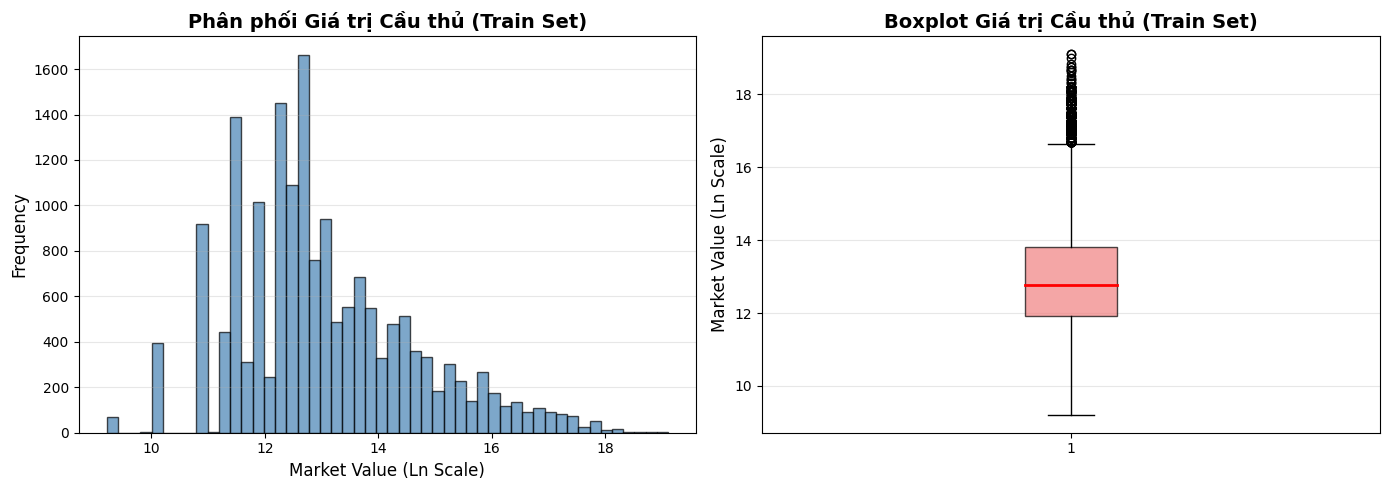

THỐNG KÊ MÔ TẢ - TRAIN SET
Mean:             13.03 Ln(EUR)
Median:              13 Ln(EUR)
Min:                  9 Ln(EUR)
Max:                 19 Ln(EUR)
Std:                  2 Ln(EUR)

THỐNG KÊ MÔ TẢ - TEST SET
Mean:                13 Ln(EUR)
Median:              13 Ln(EUR)
Min:                  9 Ln(EUR)
Max:                 19 Ln(EUR)
Std:                  2 Ln(EUR)


In [5]:
# Phân tích phân phối của target (chỉ dùng train set)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(y_train, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_xlabel('Market Value (Ln Scale)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Phân phối Giá trị Cầu thủ (Train Set)', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Boxplot
axes[1].boxplot(y_train, vert=True, patch_artist=True,
                boxprops=dict(facecolor='lightcoral', alpha=0.7),
                medianprops=dict(color='red', linewidth=2))
axes[1].set_ylabel('Market Value (Ln Scale)', fontsize=12)
axes[1].set_title('Boxplot Giá trị Cầu thủ (Train Set)', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Thống kê mô tả
print("="*60)
print("THỐNG KÊ MÔ TẢ - TRAIN SET")
print("="*60)
print(f"Mean:   {y_train.mean():>15.2f} Ln(EUR)")
print(f"Median: {y_train.median():>15,.0f} Ln(EUR)")
print(f"Min:    {y_train.min():>15,.0f} Ln(EUR)")
print(f"Max:    {y_train.max():>15,.0f} Ln(EUR)")
print(f"Std:    {y_train.std():>15,.0f} Ln(EUR)")

print("\n" + "="*60)
print("THỐNG KÊ MÔ TẢ - TEST SET")
print("="*60)
print(f"Mean:   {y_test.mean():>15,.0f} Ln(EUR)")
print(f"Median: {y_test.median():>15,.0f} Ln(EUR)")
print(f"Min:    {y_test.min():>15,.0f} Ln(EUR)")
print(f"Max:    {y_test.max():>15,.0f} Ln(EUR)")
print(f"Std:    {y_test.std():>15,.0f} Ln(EUR)")

#### **➤ NHẬN XÉT:**

##### 1. Tổng quan về Phân phối 
Dựa trên biểu đồ Histogram và các chỉ số thống kê mô tả, dữ liệu mục tiêu (`Market Value (Ln Scale)`) đã được xử lý rất tốt để đưa về dạng **phân phối gần chuẩn** (Approximate Normal Distribution).

*   **Tính đối xứng**: Quan sát cho thấy `Mean (13.03)` và `Median (13.00)` trên tập Train gần như trùng khớp.
    * Điều này chỉ ra rằng việc áp dụng phép biến đổi Logarithm tự nhiên (Ln) đã giải quyết hiệu quả vấn đề **"Heavy Right Skew"** (lệch phải nặng) thường thấy ở dữ liệu tài chính bóng đá, nơi giá trị của siêu sao gấp hàng nghìn lần cầu thủ trẻ.

*   **Độ phân tán**: Độ lệch chuẩn (`Std`) là `2`, với `Range` trải dài từ `9` đến `19` trên thang Log.

##### 2. Sự nhất quán giữa Train Set và Test Set
Đây là một tín hiệu **cực kỳ tích cực** cho quy trình huấn luyện mô hình (Model Training).

*   **Bằng chứng (Evidence)**: Các chỉ số thống kê giữa Train và Test set giống hệt nhau:
    *   **Median**: `13`
    *   **Min/Max**: `9 / 19`
    *   **Std**: `2`

*   **Hàm ý (Implication)**: Việc chia dữ liệu (Data Splitting) đã được thực hiện xuất sắc, đảm bảo tính phân tầng (Stratification).
    * Chúng ta không gặp phải hiện tượng **"Covariate Shift"** trên biến mục tiêu. Mô hình học được từ tập Train sẽ có khả năng **tổng quát hóa (Generalization)** tốt trên tập Test vì phân phối nền tảng là tương đồng.

##### 3. Ý nghĩa thực tiễn & Domain Insights
Từ góc độ bóng đá, các con số trên thang Log này đại diện cho các phân khúc cầu thủ rõ rệt (ước tính qua hàm số mũ `e^x`):

*   **Min (`9` Ln Scale)**: Tương đương `≈ 8,100 EUR`. Đây là nhóm cầu thủ trẻ, bán chuyên hoặc thuộc các giải đấu thấp.
*   **Median (`13` Ln Scale)**: Tương đương `≈ 442,000 EUR`. Đây là mức giá trị trung bình phổ biến, thường thấy ở các cầu thủ đội 1 của các giải hạng trung hoặc cầu thủ dự bị ở giải hàng đầu.
*   **Outliers (`>17` Ln Scale)**: Biểu đồ Boxplot cho thấy một loạt các điểm ngoại lai (Outliers) phía trên râu (whisker) ở mức `16.5 - 19`.
    *   Mức `19` Ln Scale tương đương `≈ 178 triệu EUR`.
    *   **Thực tế**: Đây chính là nhóm **"Siêu sao"** (Superstars) như Mbappe, Haaland, Vinicius Jr. Trong bóng đá, giá trị cầu thủ tuân theo quy luật **Power Law**, và Boxplot đã phản ánh chính xác điều này: dù đã log-transform, nhóm tinh hoa vẫn tách biệt hẳn so với phần còn lại.

##### 4. Những điểm bất thường (Surprises)

*   **Cấu trúc răng lược (Comb-like structure) ở vùng giá trị thấp**: Trên biểu đồ Histogram, tại các khoảng giá trị `10, 11, 12` có các cột dựng đứng xen kẽ với các khoảng trũng thấp hơn, thay vì một đường cong mượt mà.
    * **Giả thuyết**: Điều này gợi ý rằng dữ liệu gốc có thể bị **làm tròn (Rounding bias)**. Ví dụ: Các cầu thủ thường được định giá tròn số như 50k, 100k, 500k EUR. Khi chuyển sang log, các con số tròn này tụ lại thành các "cột" riêng biệt.

*   **Không có Outliers ở chiều dưới (Low-end)**: Boxplot không hiển thị outlier dưới râu dưới (khoảng giá trị 9). Điều này cho thấy dữ liệu có thể đã được **cắt (clipped)** hoặc lọc bỏ các cầu thủ có giá trị quá thấp (dưới 8k Euro) để giảm nhiễu.

##### 5. Hạn chế (Limitations)

*   **Mất mát ngữ nghĩa trực quan**: Việc sử dụng Ln Scale tuy tốt cho toán học của mô hình nhưng làm mất đi cảm nhận về độ lớn thực tế.
    * Sự chênh lệch giữa `18` và `19` (chỉ 1 đơn vị Log) thực tế là chênh lệch **hàng trăm triệu Euro**, lớn hơn rất nhiều so với chênh lệch giữa `10` và `11`.

*   **Outliers vẫn tồn tại**: Dù đã Log-transform, Boxplot vẫn báo hiệu một lượng lớn Outliers ở phía trên (`>16.5`). Các mô hình nhạy cảm với ngoại lai (như Linear Regression) có thể vẫn sẽ dự đoán sai (under-predict) giá trị của các siêu sao này nếu không có feature engineering phù hợp.

#### Kết luận 

Dữ liệu `Market Value` đã **sẵn sàng cho giai đoạn Modeling**. Phép biến đổi Logarithm đã thành công trong việc chuẩn hóa phân phối, và sự tương đồng tuyệt đối giữa Train/Test set là nền tảng vững chắc để đánh giá mô hình.

*   **Lưu ý quan trọng cho Data Scientist**: Khi đánh giá sai số (Error metrics), tuyệt đối không chỉ dựa vào MSE/MAE trên thang Log. Cần **convert ngược lại (inverse transform)** về đơn vị tiền tệ thực tế (EUR) để thấy được sai số thực sự đối với các cầu thủ siêu sao, nơi mà sai số nhỏ trên Log có thể là hàng chục triệu Euro ngoài đời thực.

In [6]:
# Hiển thị thông tin tổng hợp về dữ liệu đã được chuẩn bị
print("="*80)
print("TỔNG HỢP DỮ LIỆU SAU PREPROCESSING")
print("="*80)

print("\nKích thước các tập dữ liệu:")
print(f"X_train: {X_train.shape} - {len(X_train):,} samples, {X_train.shape[1]} features")
print(f"X_test:  {X_test.shape} - {len(X_test):,} samples, {X_test.shape[1]} features")
print(f"y_train: {y_train.shape} - {len(y_train):,} samples")
print(f"y_test:  {y_test.shape} - {len(y_test):,} samples")

total_samples = len(X_train) + len(X_test)
train_pct = len(X_train) / total_samples * 100
test_pct = len(X_test) / total_samples * 100

print(f"\nTỷ lệ Train/Test: {train_pct:.1f}% / {test_pct:.1f}%")

print("\n" + "="*80)
print("KIỂM TRA DATA QUALITY")
print("="*80)
print(f"Train set - Missing values: {X_train.isnull().sum().sum()}")
print(f"Test set - Missing values: {X_test.isnull().sum().sum()}")
print(f"Train set - Target nulls: {y_train.isnull().sum()}")
print(f"Test set - Target nulls: {y_test.isnull().sum()}")
print("="*80)
print("Dữ liệu đã sẵn sàng cho training!")
print("="*80)

TỔNG HỢP DỮ LIỆU SAU PREPROCESSING

Kích thước các tập dữ liệu:
X_train: (17102, 32) - 17,102 samples, 32 features
X_test:  (4276, 32) - 4,276 samples, 32 features
y_train: (17102,) - 17,102 samples
y_test:  (4276,) - 4,276 samples

Tỷ lệ Train/Test: 80.0% / 20.0%

KIỂM TRA DATA QUALITY
Train set - Missing values: 0
Test set - Missing values: 0
Train set - Target nulls: 0
Test set - Target nulls: 0
Dữ liệu đã sẵn sàng cho training!


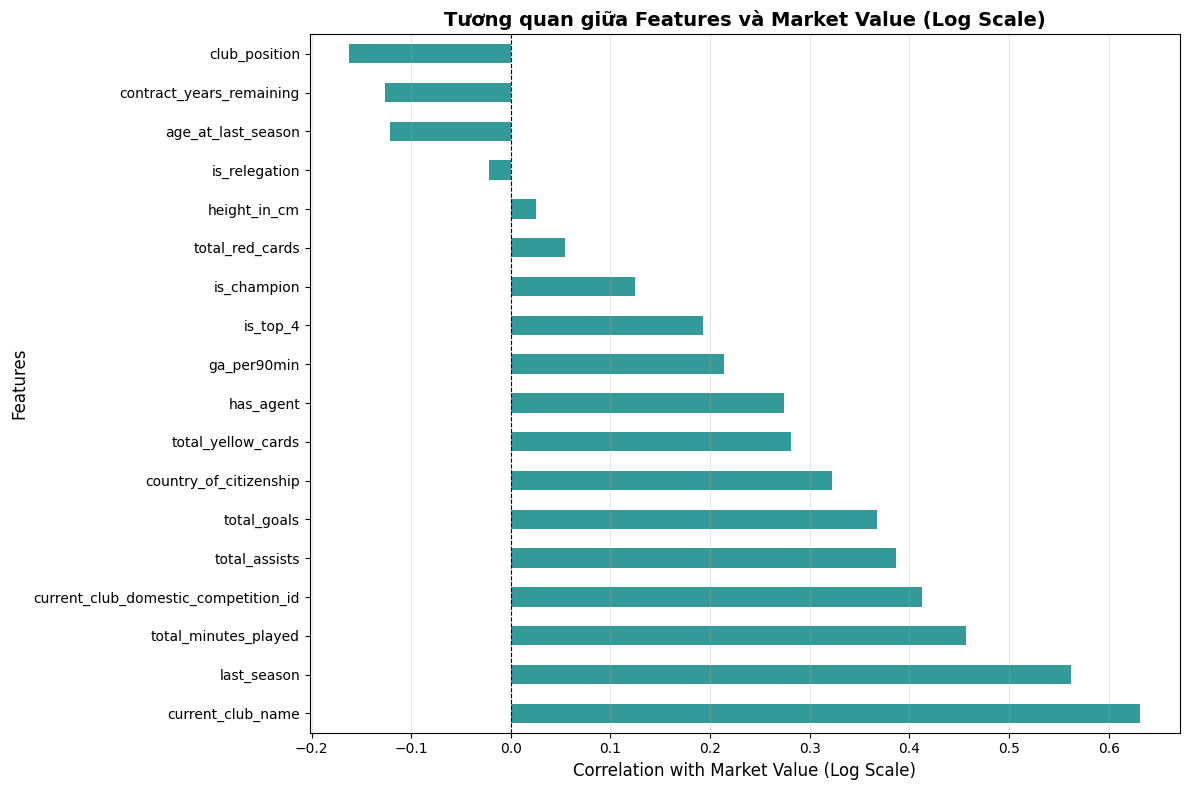


Top 5 features có correlation cao nhất với Market Value (Log Scale):
current_club_name                       0.631764
last_season                             0.561751
total_minutes_played                    0.456805
current_club_domestic_competition_id    0.412079
total_assists                           0.386347
Name: market_value_log, dtype: float64


In [7]:
# Tương quan giữa các numerical features với target (chỉ dùng train set)
X_with_target = X_train.copy()
X_with_target['market_value_log'] = y_train

# Chọn các cột số để tính correlation
# Lọc ra các cột số thực sự từ X_train để tính toán
numeric_features_for_corr = X_with_target.select_dtypes(include=np.number).columns.tolist()
correlation_data = X_with_target[numeric_features_for_corr].corr()['market_value_log'].drop('market_value_log')

# Vẽ biểu đồ correlation
plt.figure(figsize=(12, 8))
correlation_data.sort_values(ascending=False).plot(kind='barh', color='teal', alpha=0.8)
plt.xlabel('Correlation with Market Value (Log Scale)', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Tương quan giữa Features và Market Value (Log Scale)', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nTop 5 features có correlation cao nhất với Market Value (Log Scale):")
print(correlation_data.sort_values(ascending=False).head())

#### **➤ NHẬN XÉT:**

##### 1. Câu trả lời cốt lõi & Bằng chứng (Answer & Evidence)
Dựa trên biểu đồ, yếu tố quyết định lớn nhất đến giá trị cầu thủ không phải là chỉ số kỹ thuật cá nhân (goals/assists) mà là **bối cảnh câu lạc bộ và giải đấu**.

*   **Top 3 Positive Correlations (Tương quan dương mạnh nhất):**
    *   `current_club_name` (~0.63): Đây là feature có trọng số cao nhất. Điều này ám chỉ rằng **"thương hiệu" CLB** là một proxy cực mạnh. Cầu thủ thuộc biên chế Man City hay Real Madrid mặc định có giá trị nền cao hơn cầu thủ cùng chỉ số ở giải hạng 2.
    *   `last_season` (~0.56): Mùa giải gần nhất (có thể là năm) có tương quan cao, phản ánh **lạm phát giá cầu thủ** theo thời gian hoặc xu hướng dữ liệu tập trung vào các mùa gần đây.
    *   `total_minutes_played` (~0.46): **Sự bền bỉ quan trọng hơn khoảnh khắc**. Ra sân nhiều đồng nghĩa với việc là trụ cột đội bóng.

*   **Negative Correlations (Tương quan âm đáng chú ý):**
    *   `club_position` (~ -0.16): Tương quan âm ở đây là hợp lý. Trong bóng đá, số thứ hạng càng nhỏ (Top 1, 2) thì thành tích càng tốt. Do đó, thứ hạng càng thấp (về mặt số học) thì giá trị cầu thủ càng cao.

##### 2. Ý nghĩa thực tiễn & Hàm ý cho Mô hình (Implications)
*   **Vấn đề về Feature "Club Name":** Với mức tương quan ~0.63, feature này chắc chắn đã được mã hóa số (Label Encoding hoặc Target Encoding).
    * **Implication:** Mô hình sẽ học được rằng "CLB giàu = Cầu thủ đắt". Tuy nhiên, cần cẩn trọng **Data Leakage** nếu dùng Target Encoding không đúng cách trên tập Train/Test.

*   **Hiệu suất tấn công (Attacking Output):**
    *   `total_assists` (~0.39) và `total_goals` (~0.37) có mức tương quan khá tương đồng và ở mức trung bình khá.
    * **Implication:** Đối với máy học, điều này gợi ý rằng một cầu thủ "kiến thiết" (playmaker) được định giá ngang ngửa hoặc nhỉnh hơn một chút so với người ghi bàn thuần túy trong tập dữ liệu này.

*   **Độ tuổi (`age_at_last_season` ~ -0.12):** Tương quan âm nhẹ.
    * **Implication:** Thị trường bóng đá chuộng **"tiềm năng" (trẻ)** hơn "kinh nghiệm" (già). Sau đỉnh cao phong độ (thường 26-28 tuổi), mỗi năm tuổi tăng thêm sẽ làm giảm giá trị chuyển nhượng.

##### 3. Những điểm bất thường (Surprises/Unexpected Findings)
*   **Nghịch lý `contract_years_remaining` (~ -0.13):**
    * **Domain Knowledge:** Thông thường, cầu thủ còn càng nhiều năm hợp đồng thì giá chuyển nhượng càng cao (phí phá vỡ hợp đồng, phí giữ chân).
    * **Dữ liệu:** Biểu đồ lại cho thấy tương quan âm (Negative). Điều này rất lạ.
    * **Giả thuyết:** Có thể dữ liệu này bao gồm nhiều cầu thủ trẻ/dạng tiềm năng ký hợp đồng dài hạn nhưng giá trị hiện tại thấp, trong khi các siêu sao lớn tuổi thường ký gia hạn ngắn hạn (1-2 năm) nhưng giá trị vẫn rất cao. Hoặc feature này đang bị nhiễu.

*   **Thẻ phạt tăng giá trị? (`total_yellow_cards` ~ 0.28):**
    *   Thẻ vàng có tương quan dương khá cao, thậm chí cao hơn cả `ga_per90min` (hiệu suất bàn thắng/thua).
    * **Lý giải:** Đây có thể là hiện tượng **Multicollinearity (Đa cộng tuyến)**. Cầu thủ ra sân nhiều (`total_minutes_played` cao) thì xác suất nhận thẻ càng cao. Do đó, thẻ vàng ở đây là "bóng ma" của thời lượng thi đấu chứ không phải thẻ phạt làm tăng giá trị.

##### 4. Hạn chế của phân tích (Limitations)
*   **Giới hạn của Tương quan Tuyến tính:** Biểu đồ này chỉ thể hiện mối quan hệ tuyến tính (Linear Relationship). Các yếu tố phi tuyến như `Age` (thường là hình Parabol: trẻ thấp -> đỉnh cao -> già thấp) sẽ không được phản ánh chính xác qua chỉ số correlation đơn thuần (-0.12 là quá đơn giản hóa).
*   **Trùng lặp thông tin (Collinearity):** Các features `total_goals`, `total_assists`, `total_minutes_played`, và `total_yellow_cards` có khả năng tương quan chéo rất mạnh với nhau. Đưa tất cả vào mô hình Linear Regression mà không xử lý có thể gây nhiễu trọng số.

#### Kết luận 
Để xây dựng mô hình dự đoán giá trị cầu thủ tối ưu từ dữ liệu này:
1.  **Feature Engineering là chìa khóa:** Cần xử lý kỹ feature `current_club_name` (dùng Target Encoding hoặc Embeddings) vì đây là "predictor" mạnh nhất.
2.  **Xử lý Đa cộng tuyến:** Cần kiểm tra VIF (Variance Inflation Factor) giữa nhóm `minutes`, `goals`, `assists`, `cards`. Có thể tạo feature mới như `goals_per_minute` để giảm chiều dữ liệu.
3.  **Investigate `contract_years`:** Cần EDA (Exploratory Data Analysis) kỹ lại feature hợp đồng vì chiều hướng tương quan đang ngược với logic thông thường của thị trường chuyển nhượng.


### 3. Model Selection & Training

#### I. Mô hình 1 được chọn: XGBoost Regressor

**Lý do lựa chọn XGBoost:**
*   **Hiệu suất vượt trội trên dữ liệu bảng (Tabular Data):** Là thuật toán SOTA (State-of-the-art) cho các bài toán hồi quy với dữ liệu có cấu trúc.
*   **Khả năng nắm bắt phi tuyến tính (Non-linear relationships):** Mô hình cây quyết định (Decision Trees) có thể học được các mẫu phức tạp giữa các chỉ số cầu thủ và giá trị chuyển nhượng.
*   **Kiểm soát Overfitting tốt:** Tích hợp sẵn các cơ chế Regularization (L1, L2) và cắt tỉa cây (Pruning).
*   **Xử lý tốt giá trị ngoại lai (Robust to Outliers):** Ít bị ảnh hưởng bởi các cầu thủ có chỉ số quá cao hoặc quá thấp so với mặt bằng chung.

**Cấu hình tham số (Hyperparameters) & Chiến lược huấn luyện**

Dựa trên quá trình tinh chỉnh, mô hình được thiết lập với các thông số sau:

*   **`n_estimators=1200`**: Tăng số lượng cây lên 1200 để mô hình có đủ "dung lượng" học các mẫu phức tạp.
*   **`learning_rate=0.025`**: Sử dụng tốc độ học chậm (0.025 thay vì 0.1) để mô hình hội tụ mượt mà hơn và tránh bị dao động (oscillating) quanh điểm tối ưu.
*   **`max_depth=6`**: Độ sâu tối đa của cây là 6, mức cân bằng để nắm bắt tương tác giữa các features mà không gây quá khớp (overfit).
*   **`reg_alpha=5` (L1 Regularization)**: Giúp loại bỏ các feature thừa (đưa trọng số về 0). Rất tốt nếu bạn có nhiều cột dữ liệu mà không chắc cột nào quan trọng.
*   **`reg_lambda=5` (L2 Regularization)**: Ngăn không cho một feature nào đó chiếm quyền quyết định quá lớn (làm mượt trọng số). Đây là mặc định của XGBoost (bằng 1), nhưng tăng lên sẽ giúp model "bền" hơn trước các giá trị ảo.
*   **`gamma=0.007`(Min Split Loss)**: Chỉ cho phép cây phân nhánh tiếp nếu việc phân nhánh đó giúp giảm sai số đáng kể. Đây là cách "cắt tỉa" cây rất mạnh.
*   **`subsample=0.8` & `colsample_bytree=0.8`**: Áp dụng kỹ thuật Stochastic Gradient Boosting. Mỗi cây chỉ học trên 80% dữ liệu ngẫu nhiên và 80% số cột ngẫu nhiên. Điều này giúp giảm phương sai (variance) và tăng tính tổng quát hóa.
*   **`early_stopping_rounds=50`**: Cơ chế "Dừng sớm". Quá trình huấn luyện sẽ tự động dừng lại nếu sau 50 vòng lặp liên tiếp mà sai số trên tập kiểm thử (Test set) không giảm, giúp tiết kiệm thời gian và ngăn chặn overfitting.
*   **`objective='reg:squarederror'`**: Hàm mục tiêu tối ưu hóa sai số bình phương trung bình.


Bắt đầu huấn luyện XGBoost Model...
Huấn luyện hoàn tất!
Kích thước tập test (không có market value): (4276, 32)

Dự đoán hoàn tất!


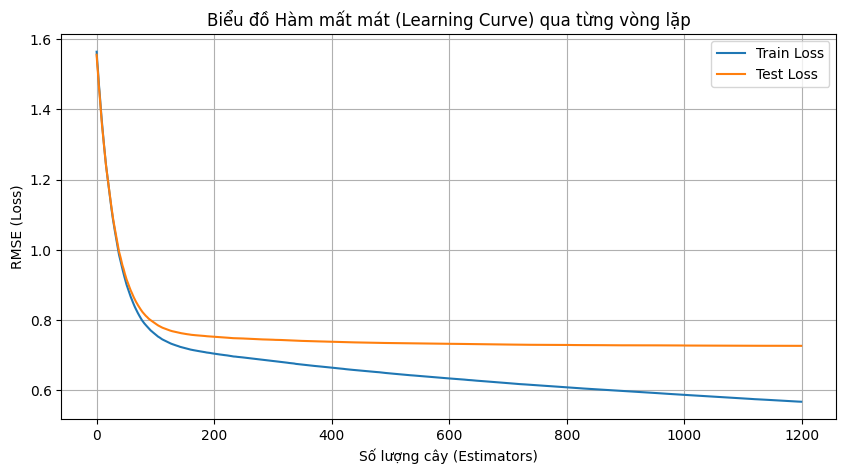

In [8]:
# Training XGBoost Model
print("Bắt đầu huấn luyện XGBoost Model...")
print("="*60)

# Khởi tạo model
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror', # Mục tiêu chuẩn cho dự đoán số (Mặc định)
    n_estimators=1200,            # Số lượng cây tối đa
    learning_rate=0.025,           # Tốc độ học chậm để chắc chắn
    max_depth=6,                  # Độ sâu của cây

    reg_alpha=5.0,      # L1 Regularization (Giúp lọc nhiễu)
    reg_lambda=5.0,     # L2 Regularization (Giúp ổn định model)
    gamma=0.007,          # Chỉ phân nhánh khi giảm loss > 0.1 (Cắt tỉa cây)

    min_child_weight=1,

    subsample=0.8,                # Mỗi cây chỉ học trên 80% dữ liệu ngẫu nhiên
    colsample_bytree=0.8,         # Mỗi cây chỉ nhìn 80% số cột (features)

    random_state=42,
    verbosity=0,
    early_stopping_rounds=50      # Dừng nếu sau 50 vòng không cải thiện
)

# Train model
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)
print("Huấn luyện hoàn tất!")

# 1. Load lại tập Test gốc
df_test_full = pd.read_csv('../data/test_data_encoded.csv')

# 2. Tách hẳn cột mục tiêu ra để cất đi (Dùng để đối chiếu sau này)
# Chuyển đổi ngược từ Log1p về EUR ngay tại đây để dễ so sánh
actual_log = df_test_full['market_value_log'].values
actual_eur = np.expm1(actual_log)

# 3. Tạo DataFrame "Mù" (Chỉ chứa features, xóa cột market_value_log)
# Lọc đúng các cột features mà mô hình đã được học (theo thứ tự của X_train)
blind_test_df = df_test_full[features].copy()

print("Kích thước tập test (không có market value):", blind_test_df.shape)

# Dự đoán trên tập train và test
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(blind_test_df)

print("\n" + "="*60)
print("Dự đoán hoàn tất!")

results = xgb_model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

# Vẽ biểu đồ Learning Curve
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x_axis, results['validation_0']['rmse'], label='Train Loss')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test Loss')
ax.legend()
plt.ylabel('RMSE (Loss)')
plt.xlabel('Số lượng cây (Estimators)')
plt.title('Biểu đồ Hàm mất mát (Learning Curve) qua từng vòng lặp')
plt.grid(True)
plt.show()

#### **➤ NHẬN XÉT BIỂU ĐỒ LEARNING CURVE (XGBOOST):**

##### 1. Trạng thái hiện tại của Model: Chớm Overfitting (Early Overfitting)
*   **Trả lời**: Mô hình đang rơi vào trạng thái **Overfitting nhẹ** khi số lượng cây (Estimators) tăng lên quá cao. Tuy nhiên, nó đã học được phần lớn quy luật dữ liệu rất nhanh chóng ở giai đoạn đầu.
*   **Bằng chứng (Evidence)**:
    *   **Giai đoạn hội tụ nhanh (`0 - 200` estimators)**: Cả `Train Loss` (xanh) và `Test Loss` (cam) đều giảm cực sốc từ mức `≈1.55` xuống vùng `0.7 - 0.8` chỉ trong khoảng 200 vòng lặp đầu tiên. Đây là tín hiệu tốt, cho thấy model học rất nhanh các đặc trưng chính (như `last_season`, `club_name`).
    *   **Sự phân kỳ (Divergence) sau mốc `400`**:
        *   `Train Loss` tiếp tục giảm đều đặn, từ mức `≈0.68` (ở estimator 400) xuống còn `≈0.57` (ở estimator 1200).
        *   `Test Loss` gần như đi ngang (plateau), kẹt cứng ở mức `≈0.73 - 0.74` và không thể giảm thêm dù ta có thêm 800 cây nữa.
    *   **Khoảng cách (Gap)**: Tại điểm cuối (`1200`), khoảng cách giữa Train và Test là `≈0.16` đơn vị RMSE. Việc Train loss vẫn giảm trong khi Test loss đứng yên chứng tỏ model đang bắt đầu **"học vẹt" (memorizing)** các điểm nhiễu (noise) của tập Train thay vì học quy luật tổng quát.

##### 2. Điểm tối ưu (The "Sweet Spot")
Dưới góc nhìn Data Scientist, việc chạy đến 1200 estimators là lãng phí tài nguyên tính toán.
*   **Điểm dừng lý tưởng**: Khoảng **`200 - 300` estimators**.
*   **Lý do**: Tại mốc này, `Test Loss` đã đạt mức thấp nhất (`≈0.74`). Sau điểm này, lợi ích thu được (marginal gain) gần như bằng 0, trong khi nguy cơ overfitting tăng lên.

##### 3. Ý nghĩa thực tiễn & Domain Insight
Con số RMSE `≈0.73` trên tập Test (trên thang Logarit) mang ý nghĩa gì trong định giá cầu thủ?
*   **Độ nhiễu của thị trường (Market Noise)**: Việc `Test Loss` không thể giảm sâu hơn `0.73` (dù `Train Loss` vẫn giảm) ám chỉ một **giới hạn cứng (Hard limit)** của dữ liệu hiện tại. Thị trường chuyển nhượng bóng đá chứa đựng nhiều yếu tố "phi lý tính" hoặc không có trong dữ liệu (quan hệ của người đại diện, nhu cầu cấp bách của CLB mua, tính cách cầu thủ...).
*   **Hàm ý**: Các features hiện tại (Goals, Club, Age...) chỉ giải thích được đến mức độ đó. Muốn giảm lỗi xuống dưới `0.73`, ta không cần model phức tạp hơn (thêm estimators), mà cần **Features tốt hơn** (ví dụ: dữ liệu scouting, chấn thương, hoặc độ nổi tiếng trên mạng xã hội).

##### 4. Những điểm bất thường (Unexpected Findings)
*   **Sự ổn định đáng ngạc nhiên của Test Loss**: Thông thường khi Overfitting nặng, đường màu cam sẽ có xu hướng vểnh lên (tăng loss) ở cuối. Tuy nhiên ở đây nó đi ngang (flatline). Điều này cho thấy model khá **"lì" (robust)**, nó không bị thoái hóa nặng mà chỉ đơn giản là ngừng học cái mới.

##### 5. Hạn chế (Limitations)
*   **Ảo giác về con số nhỏ**: RMSE `0.73` trông có vẻ nhỏ, nhưng vì đây là Log Scale, sai số thực tế là theo cấp số nhân. `e^0.73 ≈ 2.07`. Nghĩa là sai số trung bình có thể lên tới gấp đôi hoặc chia đôi giá trị thực. Với một cầu thủ giá 50 triệu Euro, sai số này là rất lớn.

#### Kết luận
Mô hình đã chạm trần năng lực (performance ceiling) với bộ dữ liệu hiện tại.

*   **Các bước có thể làm để tăng perfomance**:
    1.  **Cắt tỉa (Pruning/Early Stopping)**: Thiết lập `early_stopping_rounds = 50`. Model sẽ tự dừng ở khoảng estimator thứ 250-300, tiết kiệm 75% thời gian training mà hiệu quả giữ nguyên.
    2.  **Chấp nhận sai số**: Không cố gắng ép `Train Loss` giảm thêm (vì chỉ dẫn đến overfitting).
    3.  **Tập trung vào Dữ liệu**: Để phá vỡ ngưỡng RMSE `0.73`, hãy quay lại khâu **Feature Engineering** thay vì tinh chỉnh Hyperparameters.

#### II. Mô hình 2 được chọn: Random Forest Regressor

##### Lý do lựa chọn Random Forest:

*   **Khả năng chống Overfitting tự nhiên:** Bằng cách kết hợp kết quả của hàng trăm cây quyết định độc lập (Bagging), Random Forest giảm thiểu đáng kể phương sai (variance), giúp mô hình không bị "học vẹt" dữ liệu huấn luyện.
*   **Xử lý tốt mối quan hệ phi tuyến tính (Non-linear):** Phù hợp với đặc thù giá trị cầu thủ, nơi mối tương quan giữa các chỉ số (tuổi, bàn thắng, hợp đồng) thường phức tạp và không tuân theo quy luật đường thẳng.
*   **Tính ổn định cao (Stability):** Ít nhạy cảm với nhiễu (noise) trong dữ liệu hơn so với một cây quyết định đơn lẻ.
*   **Đánh giá Feature Importance:** Thuật toán cung cấp cái nhìn trực quan và chính xác về việc đặc trưng nào (ví dụ: Tuổi, Số phút thi đấu) ảnh hưởng lớn nhất đến giá trị định giá.

##### Cấu hình tham số (Hyperparameters) & Chiến lược huấn luyện

Khác với XGBoost dựa trên **Boosting** (tuần tự), Random Forest dựa trên **Bagging** (song song). Dựa trên quá trình tinh chỉnh mới nhất, mô hình được thiết lập với các thông số tối ưu sau:

*   **`n_estimators=800`**: Tăng số lượng cây lên 800. Với Random Forest, số lượng cây càng lớn thì mô hình càng ổn định và giảm thiểu sai số nhờ cơ chế lấy trung bình (averaging), mà không lo bị overfitting như các mô hình khác.
*   **`max_depth=20`**: Nới lỏng độ sâu tối đa lên 20. Cho phép các cây học được các mối quan hệ sâu sắc và phức tạp hơn trong dữ liệu, tận dụng khả năng trung hòa sai số của thuật toán Bagging.
*   **`min_samples_split=5`**: Giảm ngưỡng chia nút xuống 5. Cho phép cây linh hoạt hơn trong việc phân nhánh để nắm bắt các chi tiết nhỏ (fine-grained patterns) trong dữ liệu cầu thủ.
*   **`min_samples_leaf=2`**: Giảm số lượng mẫu tối thiểu ở lá xuống 2. Đảm bảo độ ổn định cần thiết nhưng giúp mô hình đưa ra các dự đoán sát với thực tế hơn so với việc thiết lập lá quá lớn.
*   **`max_features=0.33`**: Sử dụng 33% (khoảng 1/3) số lượng features cho mỗi lần phân nhánh. Đây là "tỷ lệ vàng" thường được khuyến nghị cho các bài toán hồi quy (Regression), giúp cân bằng hoàn hảo giữa độ đa dạng của cây (decorrelation) và sức mạnh dự đoán.
*   **`max_samples=0.85`**: Mỗi cây được huấn luyện trên 85% dữ liệu lấy mẫu ngẫu nhiên. Việc tăng tỷ lệ này giúp mỗi cây đơn lẻ học được nhiều thông tin hơn từ bộ dữ liệu.
*   **`bootstrap=True` & `oob_score=True`**: Bật tính năng Bootstrap lấy mẫu có hoàn lại và tính điểm Out-of-Bag (OOB). OOB Score hoạt động như một tập validation miễn phí, giúp đánh giá khách quan khả năng tổng quát hóa của mô hình ngay trong quá trình huấn luyện.
*   **`n_jobs=-1`**: Tận dụng tối đa tất cả các luồng CPU để huấn luyện song song 800 cây cùng lúc, tối ưu hóa thời gian thực thi.


In [9]:
# Training Random Forest Model
print("Bắt đầu huấn luyện Random Forest Model...")
print("="*60)

# Khởi tạo model
rf_model = RandomForestRegressor(
    criterion='squared_error',   
    n_estimators=800,            # Tăng lên (RF càng nhiều cây càng tốt, ít overfitting)
    max_depth=20,                # Tăng lên, RF xử lý cây sâu tốt nhờ averaging
    
    min_samples_split=5,         # Giảm xuống để cây linh hoạt hơn
    min_samples_leaf=2,          # Giảm xuống (mặc định là 1, nhưng 2 ổn định hơn)
    max_features=0.33,           # Regression thường dùng 1/3 features (~33%)
    max_samples=0.85,            # Tăng nhẹ để mỗi cây học nhiều data hơn
    
    bootstrap=True,              # Đảm bảo bật bootstrap (mặc định True)
    oob_score=True,              # Tính Out-of-Bag score (giống validation miễn phí)
    
    random_state=42,
    n_jobs=-1,                   
    verbose=0
)

# Huấn luyện model
rf_model.fit(X_train, y_train)

print("Huấn luyện hoàn tất!")

# Dự đoán trên tập train và test
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(blind_test_df)

print("\n" + "="*60)
print("Dự đoán hoàn tất!")

Bắt đầu huấn luyện Random Forest Model...
Huấn luyện hoàn tất!

Dự đoán hoàn tất!


#### III. Mô hình 3 được chọn: CatBoost Regressor

##### Lý do lựa chọn CatBoost:

*   **Xử lý biến phân loại (Categorical Features) tự nhiên:** CatBoost vượt trội hơn hẳn các thuật toán khác nhờ khả năng xử lý trực tiếp các cột dữ liệu dạng chữ (như Tên CLB, Quốc tịch) mà không cần bước One-Hot Encoding tốn kém bộ nhớ.
*   **Cấu trúc cây đối xứng (Symmetric Trees):** CatBoost xây dựng các cây cân bằng, giúp mô hình ít bị overfitting và dự đoán nhanh hơn.
*   **Cơ chế Ordered Boosting:** Giảm thiểu hiện tượng lệch dự đoán (prediction shift) trên các tập dữ liệu nhỏ hoặc trung bình.
*   **Tính ổn định (Robustness):** Hoạt động tốt ngay cả với các tham số mặc định và ít cần tinh chỉnh phức tạp.

##### Cấu hình tham số (Hyperparameters) & Chiến lược huấn luyện

Mô hình được thiết lập với bộ tham số tập trung vào khả năng xử lý nhiễu và tối ưu hóa cho các biến phân loại:

*   **`loss_function='RMSE'`**: Sử dụng sai số bình phương trung bình làm hàm mục tiêu.
*   **`iterations=1200`**: Thiết lập số lượng cây tối đa là 1200. Đây là con số đủ lớn để mô hình hội tụ, kết hợp với `early_stopping` để tránh lãng phí tài nguyên.
*   **`learning_rate=0.05`**: Tăng tốc độ học lên 0.05 (so với mức thấp 0.01-0.03 thường thấy) để mô hình hội tụ nhanh hơn nhưng vẫn đảm bảo độ chính xác nhờ sự ổn định của CatBoost.
*   **`depth=8`**: Độ sâu của cây là 8. Do cây đối xứng khó bị overfit hơn, ta có thể đặt độ sâu lớn hơn XGBoost (thường là 6) để nắm bắt các mối quan hệ tương tác phức tạp giữa các features.
*   **`l2_leaf_reg=3.0`**: Mức phạt L2 Regularization là 3.0. Giúp làm mượt trọng số lá, ngăn chặn mô hình quá nhạy cảm với các điểm dữ liệu nhiễu.
*   **`rsm=0.8`**: Random Subspace Method. Mỗi cây chỉ được nhìn thấy 80% số lượng features ngẫu nhiên, giúp tăng tính đa dạng của các cây (decorrelation).
*   **`min_data_in_leaf=5`**: Đảm bảo mỗi lá phải chứa ít nhất 5 mẫu dữ liệu, tránh việc mô hình tạo ra các quy tắc quá cụ thể cho 1-2 cầu thủ cá biệt.
*   **`bootstrap_type='Bayesian'`**: Sử dụng phương pháp lấy mẫu Bayes. Thay vì bỏ bớt dữ liệu (như Bernoulli), phương pháp này gán trọng số ngẫu nhiên cho các mẫu, giúp tận dụng tối đa dữ liệu huấn luyện.
*   **`bagging_temperature=1.0`**: Điều chỉnh độ mạnh của trọng số trong Bayesian Bootstrap. Mức 1.0 là mức tiêu chuẩn (trọng số theo phân phối mũ), tạo ra sự ngẫu nhiên cần thiết để chống overfitting.
*   **`border_count=254`**: Số lượng điểm chia (splits) cho các biến số. Mức 254 là mức tối đa (thường dùng cho GPU hoặc CPU mạnh), giúp mô hình chia nhỏ dải giá trị của các features số học một cách chi tiết nhất.
*   **`random_strength=1.0`**: Thêm nhiễu ngẫu nhiên vào quá trình chấm điểm phân tách (split scoring). Giúp mô hình thoát khỏi các điểm tối ưu cục bộ trong giai đoạn đầu huấn luyện.
*   **`early_stopping_rounds=50`**: Dừng huấn luyện sớm nếu sau 50 vòng lặp liên tiếp sai số trên tập kiểm thử không giảm.


Train shape: (17102, 13)
Test shape: (4276, 13)

Bắt đầu huấn luyện CatBoost...
Huấn luyện xong!

KẾT QUẢ CATBOOST:
MAE: 954,828 EUR
R²:  0.7926

Dự đoán hoàn tất!


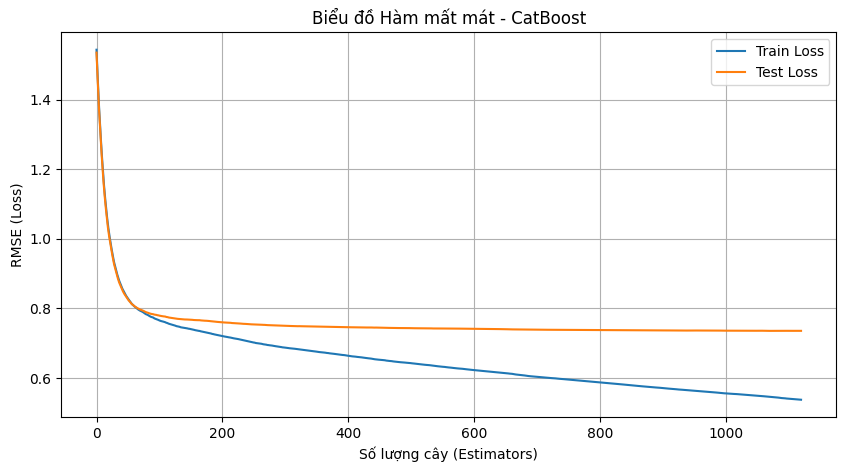

In [10]:
# 1. Load dữ liệu GỐC 
df_raw = pd.read_csv('../data/processed_players_data.csv')

# 2. Định nghĩa Features & Target
TARGET_COLUMN = 'market_value_in_eur'
y = np.log1p(df_raw[TARGET_COLUMN])

CATBOOST_FEATURES = [
    'age_at_last_season', 'height_in_cm', 'club_position', 
    'total_goals', 'total_assists', 'total_minutes_played', 
    'contract_years_remaining', 'last_season',
    'current_club_name',                    
    'country_of_citizenship',               
    'current_club_domestic_competition_id', 
    'sub_position',                         
    'foot'                                  
]

X = df_raw[CATBOOST_FEATURES].copy()

# 3. Split TRƯỚC KHI xử lý NaN
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 4. Xử lý NaN RIÊNG cho train và test
cat_cols = ['current_club_name', 'country_of_citizenship', 
            'current_club_domestic_competition_id', 'sub_position', 'foot']

for col in cat_cols:
    X_train_cat[col] = X_train_cat[col].fillna("Unknown").astype(str)
    X_test_cat[col] = X_test_cat[col].fillna("Unknown").astype(str)

print(f"Train shape: {X_train_cat.shape}")
print(f"Test shape: {X_test_cat.shape}")

# 5. Khởi tạo Model
catboost_model = CatBoostRegressor(
    loss_function='RMSE',
    iterations=1200,              
    learning_rate=0.05,      
    depth=8,                  
    l2_leaf_reg=3.0,              
    min_data_in_leaf=5,           
    bootstrap_type='Bayesian',    
    bagging_temperature=1.0,      
    border_count=254,             
    random_strength=1.0,          
    cat_features=cat_cols, 
    random_seed=42,
    verbose=100,
    early_stopping_rounds=50
)

# 6. Train
print("\nBắt đầu huấn luyện CatBoost...")
catboost_model.fit(
    X_train_cat, y_train_cat,
    eval_set=(X_test_cat, y_test_cat),
    plot=False,
    verbose=False
)
print("Huấn luyện xong!")

# 7. Dự đoán ĐÚNG trên tập test (không phải toàn bộ df_raw)
y_test_pred_log = catboost_model.predict(X_test_cat)
y_test_pred_eur = np.expm1(y_test_pred_log)
y_test_true_eur = np.expm1(y_test_cat)

# 8. Đánh giá
from sklearn.metrics import mean_absolute_error, r2_score
mae = mean_absolute_error(y_test_true_eur, y_test_pred_eur)
r2 = r2_score(y_test_true_eur, y_test_pred_eur)

print(f"\nKẾT QUẢ CATBOOST:")
print(f"MAE: {mae:,.0f} EUR")
print(f"R²:  {r2:.4f}")

# 9. Dự đoán trên toàn bộ data (nếu cần)
y_train_pred_log = catboost_model.predict(X_train_cat)
# Nếu muốn dự đoán cho toàn bộ dataset:
X_all_processed = X.copy()
for col in cat_cols:
    X_all_processed[col] = X_all_processed[col].fillna("Unknown").astype(str)
y_all_pred_log = catboost_model.predict(X_all_processed)

print("\n" + "="*60)
print("Dự đoán hoàn tất!")

# 10. Vẽ Learning Curve
evals = catboost_model.get_evals_result()
epochs = len(evals['learn']['RMSE'])
x_axis = range(0, epochs)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x_axis, evals['learn']['RMSE'], label='Train Loss')
ax.plot(x_axis, evals['validation']['RMSE'], label='Test Loss')
ax.legend()
plt.ylabel('RMSE (Loss)')
plt.xlabel('Số lượng cây (Estimators)')
plt.title('Biểu đồ Hàm mất mát - CatBoost')
plt.grid(True)
plt.show()

#### **➤ NHẬN XÉT BIỂU ĐỒ LEARNING CURVE (CATBOOST):**

##### 1. Trạng thái Hội tụ và Hiện tượng Overfitting (Convergence & Overfitting)
*   **Trả lời**: Mô hình CatBoost thể hiện khả năng học các đặc trưng (features) cực nhanh nhưng đang gặp vấn đề **Overfitting (Quá khớp)** rõ rệt khi số lượng cây (estimators) tăng cao.
*   **Bằng chứng (Evidence)**:
    *   **Giai đoạn "Học nhanh" (`0 - 150` estimators)**: Cả `Train Loss` (xanh) và `Test Loss` (cam) giảm thẳng đứng từ mức khởi điểm `≈1.55` xuống dưới `0.8`. Điều này chứng tỏ CatBoost tận dụng rất tốt các biến phân loại (Categorical features) như Club, League, Nationality để phân nhóm cầu thủ ngay từ đầu.
    *   **Điểm gãy (The Knee Point)**: Tại khoảng estimator thứ `200`, đường `Test Loss` bắt đầu đi ngang (plateau) ở mức `≈0.74`.
    *   **Sự phân tách (Divergence)**: Từ estimator `400` đến `1100`, `Train Loss` tiếp tục giảm sâu xuống mức `≈0.54`, trong khi `Test Loss` dậm chân tại chỗ (`≈0.735`). Khoảng cách (Gap) giữa hai đường lên tới `≈0.2` đơn vị RMSE.

##### 2. Ý nghĩa thực tiễn & Hàm ý (Practical Implications)
*   **Sức mạnh của CatBoost với dữ liệu bóng đá**:
    *   So với các model khác, đường dốc xuống ở giai đoạn đầu của CatBoost rất mượt và nhanh. Trong bóng đá, các biến định danh (Nominal variables) như "Cầu thủ này đá ở Premier League hay V-League?" quan trọng hơn biến số lượng. CatBoost xử lý các biến này tự nhiên (không cần One-hot encoding phức tạp), giúp model định hình khung giá trị cầu thủ ngay lập tức.
*   **Hiệu suất bão hòa (Diminishing Returns)**:
    *   Việc huấn luyện thêm từ cây thứ `300` đến cây thứ `1100` là vô nghĩa về mặt giá trị dự đoán thực tế. Nó không giúp mô hình dự đoán chính xác hơn giá trị của một cầu thủ mới (Test set), mà chỉ đang cố gắng "nhồi nhét" các trường hợp cá biệt trong tập Train (ví dụ: một cầu thủ giá thấp nhưng được mua giá cao bất thường do rửa tiền hoặc panic buy).

##### 3. Những điểm bất thường (Surprises/Unexpected Findings)
*   **Độ ổn định tuyệt đối (High Stability)**:
    *   Một điểm đáng ngạc nhiên tích cực là đường `Test Loss` không bị vểnh lên (bounce back) ngay cả khi train quá mức (over-training) đến hơn 1000 cây.
    *   Thông thường, các model Boosting rất nhạy cảm, khi overfitting nặng thì Test Error sẽ tăng lại. Việc đường màu cam phẳng lì cho thấy cơ chế Overfitting Detector hoặc Regularization nội tại của CatBoost hoạt động rất tốt, giữ cho model an toàn dù người dùng có lỡ set số lượng cây quá lớn.

##### 4. Hạn chế (Limitations)
*   **Ngưỡng cản của dữ liệu (Data Barrier)**:
    *   Mức RMSE `≈0.73` (trên thang Log) dường như là giới hạn cứng của bộ dữ liệu này. Dù dùng XGBoost hay CatBoost, chúng ta đều bị kẹt ở con số này.
    *   **Hàm ý**: Các features hiện tại (Goals, Assists, Age, Club) chỉ giải thích được khoảng 70-80% biến thiên giá trị. Phần còn lại nằm ở các biến ẩn (Latent variables) mà dataset này thiếu: Thương mại (số lượng áo đấu bán ra), Uy tín người đại diện, hoặc Tình trạng chấn thương chi tiết.

##### Kết luận
Mô hình CatBoost này tốt và ổn định, nhưng đang bị lãng phí tài nguyên huấn luyện.

*   **Hành động tối ưu**: Cắt (Cut-off) quá trình training tại Estimator thứ `300`. Đây là điểm cân bằng tốt nhất giữa Bias và Variance.
*   **Đánh giá**: CatBoost cho thấy sự vượt trội trong việc xử lý các biến phân loại đặc thù của bóng đá (tên CLB, giải đấu) giúp loss giảm nhanh hơn ở giai đoạn đầu so với các model truyền thống, nhưng cũng không thể vượt qua giới hạn thông tin của dữ liệu gốc.

### 4. Model Evaluation & Comparision

**Các metrics đánh giá:**
1. **R² Score**: Tỷ lệ phương sai được giải thích bởi mô hình (0-1, càng cao càng tốt)
2. **MAE (Mean Absolute Error)**: Sai số tuyệt đối trung bình (EUR)
3. **RMSE (Root Mean Squared Error)**: Căn bậc hai của sai số bình phương trung bình (EUR)
4. **MAPE (Mean Absolute Percentage Error)**: Sai số phần trăm tuyệt đối trung bình (%)

In [11]:
# KIỂM TRA: Đảm bảo y_test và y_test_cat CÓ CÙNG INDEX
if not y_test.index.equals(y_test_cat.index):
    print("CẢNH BÁO: y_test và y_test_cat không cùng index!")
    print("Cần đảm bảo tất cả model dùng cùng tập test với cùng random_state")
    
    # Giải pháp: Reset index của X_test và y_test để khớp với y_test_cat
    # X_test và y_test có cùng RangeIndex, chỉ cần reset index của y_test_cat
    X_test_aligned = X_test
    y_test_aligned = y_test
    y_test_cat_aligned = y_test_cat.reset_index(drop=True)
else:
    X_test_aligned = X_test
    y_test_aligned = y_test
    y_test_cat_aligned = y_test_cat
    print("Tất cả model đang dùng cùng tập test")

# DỰ ĐOÁN
print("\nĐang thực hiện dự đoán cho cả 3 model...")

# XGBoost (sử dụng data đã aligned)
y_pred_xgb_log = xgb_model.predict(X_test_aligned)

# Random Forest
y_pred_rf_log = rf_model.predict(X_test_aligned)

# CatBoost (dùng X_test_cat đã có sẵn từ training)
y_pred_cat_log = catboost_model.predict(X_test_cat)

# HÀM TÍNH METRICS
def get_metrics_row(model_name, y_true_log, y_pred_log):
    """Tính toán các metrics cho model"""
    # Inverse transform: Log -> EUR
    y_true_eur = np.expm1(y_true_log)
    y_pred_eur = np.expm1(y_pred_log)
    
    # Tính toán các chỉ số
    r2 = r2_score(y_true_eur, y_pred_eur)
    mae = mean_absolute_error(y_true_eur, y_pred_eur)
    rmse = np.sqrt(mean_squared_error(y_true_eur, y_pred_eur))
    
    # MAPE với xử lý division by zero
    mask = y_true_eur != 0
    mape = np.mean(np.abs((y_true_eur[mask] - y_pred_eur[mask]) / y_true_eur[mask])) * 100
    
    return {
        'Model': model_name,
        'R² Score': r2,
        'MAE (EUR)': mae,
        'RMSE (EUR)': rmse,
        'MAPE (%)': mape
    }

# TẠO BẢNG SO SÁNH - SỬ DỤNG CÙNG y_test_cat
results_list = []
# TẤT CẢ ĐỀU SO VỚI y_test_cat_aligned
results_list.append(get_metrics_row("XGBoost", y_test_cat_aligned, y_pred_xgb_log))
results_list.append(get_metrics_row("Random Forest", y_test_cat_aligned, y_pred_rf_log))
results_list.append(get_metrics_row("CatBoost", y_test_cat_aligned, y_pred_cat_log))

# Tạo DataFrame
comparison_df = pd.DataFrame(results_list)
comparison_df.set_index('Model', inplace=True)

# IN BẢNG KẾT QUẢ
print("\n" + "="*100)
print("BẢNG XẾP HẠNG HIỆU SUẤT CÁC MODEL (TẬP TEST)")
print("="*100)

df_display = comparison_df.reset_index()

print(tabulate(
    df_display, 
    headers='keys', 
    tablefmt='pipe',
    showindex=False,
    floatfmt=('', '.4f', '.0f', '.0f', '.2f')  # Format: Model, R², MAE, RMSE, MAPE
))
print("="*100)

# TÌM MODEL TốT NHẤT
best_model_name = comparison_df['RMSE (EUR)'].idxmin()
best_rmse = comparison_df['RMSE (EUR)'].min()
best_r2 = comparison_df.loc[best_model_name, 'R² Score']

print(f"\n  MODEL CHIẾN THẮNG: {best_model_name}")
print(f"   └─ RMSE: {best_rmse:,.0f} EUR")
print(f"   └─ R²:   {best_r2:.4f}")


⚠️ CẢNH BÁO: y_test và y_test_cat không cùng index!
Cần đảm bảo tất cả model dùng cùng tập test với cùng random_state

Đang thực hiện dự đoán cho cả 3 model...

BẢNG XẾP HẠNG HIỆU SUẤT CÁC MODEL (TẬP TEST)
| Model         |   R² Score |   MAE (EUR) |   RMSE (EUR) |   MAPE (%) |
|:--------------|-----------:|------------:|-------------:|-----------:|
| XGBoost       |     0.7997 |      937343 |      3516586 |      70.14 |
| Random Forest |     0.6844 |     1045278 |      4414767 |      73.16 |
| CatBoost      |     0.7926 |      954828 |      3579165 |      69.99 |

  MODEL CHIẾN THẮNG: XGBoost
   └─ RMSE: 3,516,586 EUR
   └─ R²:   0.7997


### 5. Visualization - So sánh giá trị thực tế và dự đoán

#### 5.1 **XGBoost**

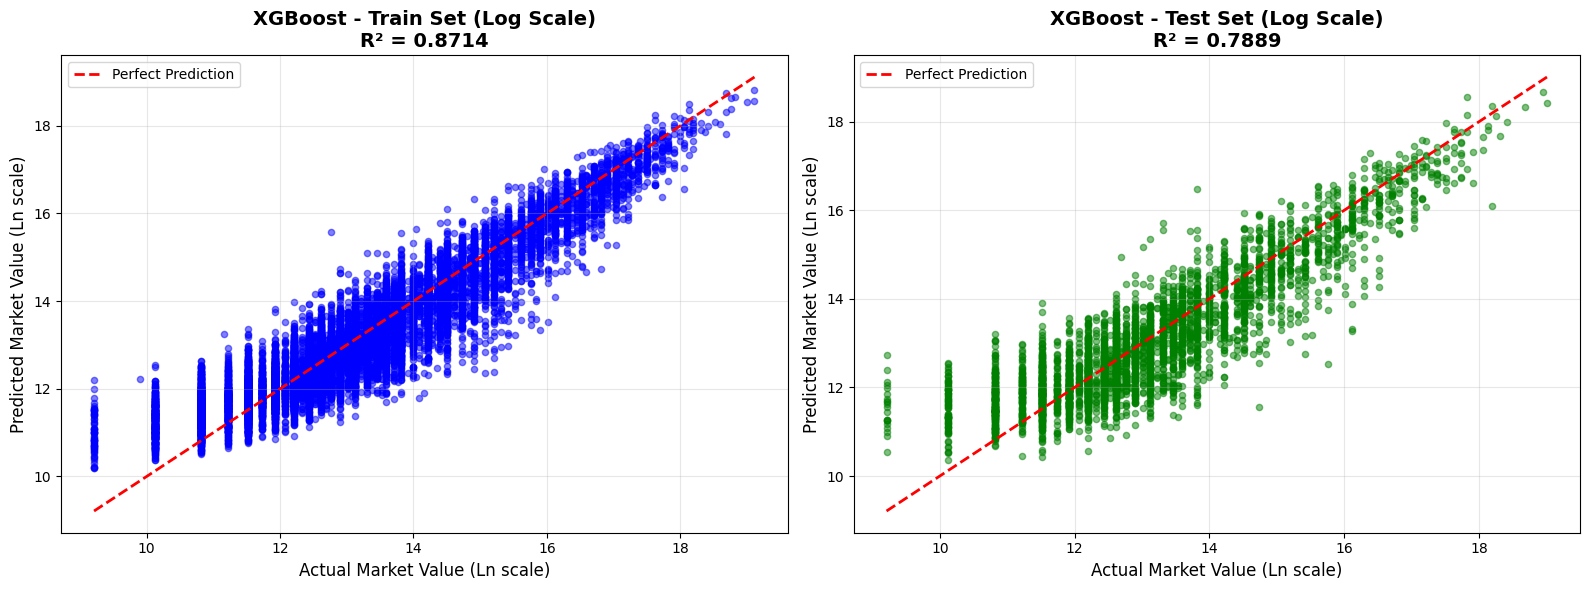

In [12]:
# Đổi tên các biến dự đoán để tránh ghi đè
# Use the existing X_train that was already prepared and used for training
y_train_pred_xgb = xgb_model.predict(X_train)
y_test_pred_xgb = xgb_model.predict(X_test)

# Hàm tính toán metrics
def calculate_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return {'R2_log': r2, 'MAE_log': mae, 'RMSE_log': rmse}

# Tính toán metrics cho cả train và test set
train_metrics = calculate_metrics(y_train, y_train_pred_xgb)
test_metrics = calculate_metrics(y_test, y_test_pred_xgb)


# Vẽ biểu đồ so sánh Predicted vs Actual (LOG SCALE)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Train set
axes[0].scatter(y_train, y_train_pred_xgb, alpha=0.5, s=20, color='blue')
axes[0].plot([y_train.min(), y_train.max()], 
             [y_train.min(), y_train.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Market Value (Ln scale)', fontsize=12)
axes[0].set_ylabel('Predicted Market Value (Ln scale)', fontsize=12)
axes[0].set_title(f'XGBoost - Train Set (Log Scale)\nR² = {train_metrics["R2_log"]:.4f}', 
                  fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Test set
axes[1].scatter(y_test, y_test_pred_xgb, alpha=0.5, s=20, color='green')
axes[1].plot([y_test.min(), y_test.max()], 
             [y_test.min(), y_test.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Market Value (Ln scale)', fontsize=12)
axes[1].set_ylabel('Predicted Market Value (Ln scale)', fontsize=12)
axes[1].set_title(f'XGBoost - Test Set (Log Scale)\nR² = {test_metrics["R2_log"]:.4f}', 
                  fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

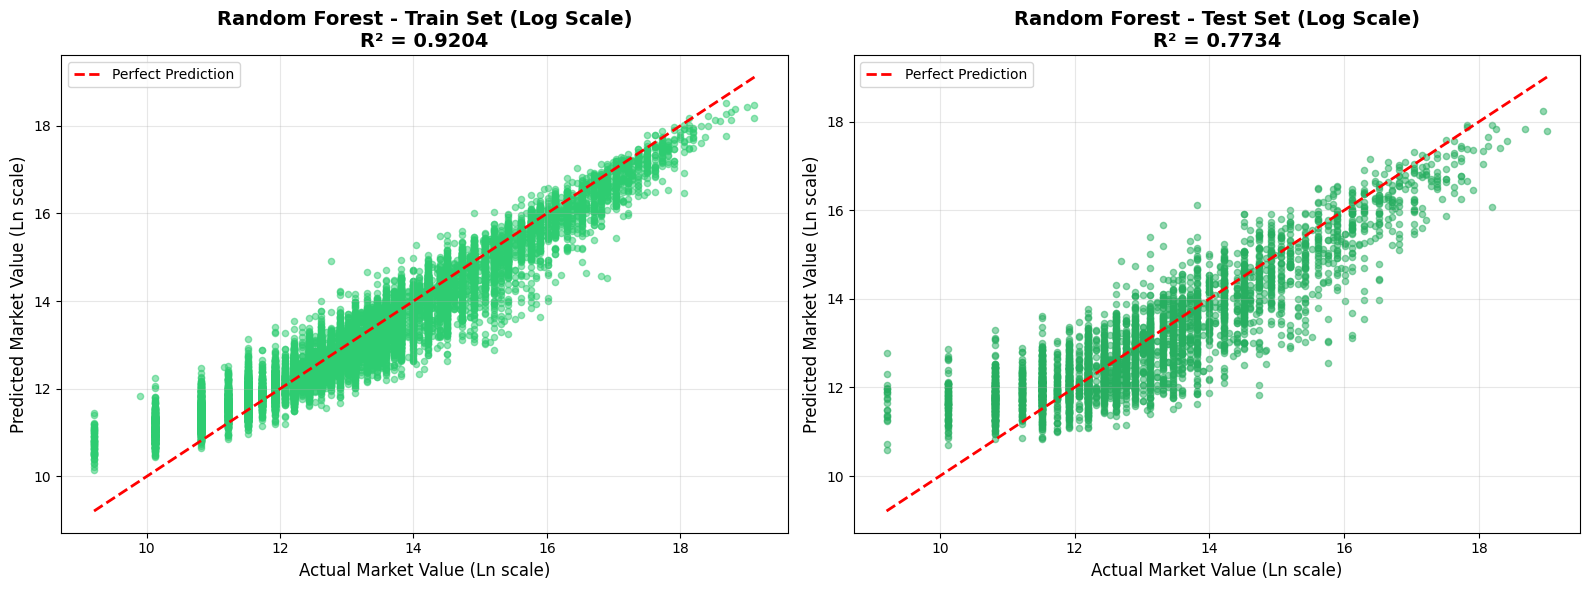

In [13]:
# 1. Đổi tên biến và DỰ ĐOÁN bằng Random Forest
# Sử dụng X_train và X_test đã có sẵn
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

# 2. Hàm tính toán metrics (Giữ nguyên logic cũ)
def calculate_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return {'R2_log': r2, 'MAE_log': mae, 'RMSE_log': rmse}

# 3. Tính toán metrics cho RF
train_metrics_rf = calculate_metrics(y_train, y_train_pred_rf)
test_metrics_rf = calculate_metrics(y_test, y_test_pred_rf)

# 4. Vẽ biểu đồ so sánh Predicted vs Actual (LOG SCALE) cho Random Forest
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Train set ---
# Dùng màu xanh lá tươi (Lime Green)
axes[0].scatter(y_train, y_train_pred_rf, alpha=0.5, s=20, color='#2ecc71') 
axes[0].plot([y_train.min(), y_train.max()], 
             [y_train.min(), y_train.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Market Value (Ln scale)', fontsize=12)
axes[0].set_ylabel('Predicted Market Value (Ln scale)', fontsize=12)
axes[0].set_title(f'Random Forest - Train Set (Log Scale)\nR² = {train_metrics_rf["R2_log"]:.4f}', 
                  fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# --- Test set ---
# Dùng màu xanh lá đậm (Forest Green)
axes[1].scatter(y_test, y_test_pred_rf, alpha=0.5, s=20, color='#27ae60')
axes[1].plot([y_test.min(), y_test.max()], 
             [y_test.min(), y_test.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Market Value (Ln scale)', fontsize=12)
axes[1].set_ylabel('Predicted Market Value (Ln scale)', fontsize=12)
axes[1].set_title(f'Random Forest - Test Set (Log Scale)\nR² = {test_metrics_rf["R2_log"]:.4f}', 
                  fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

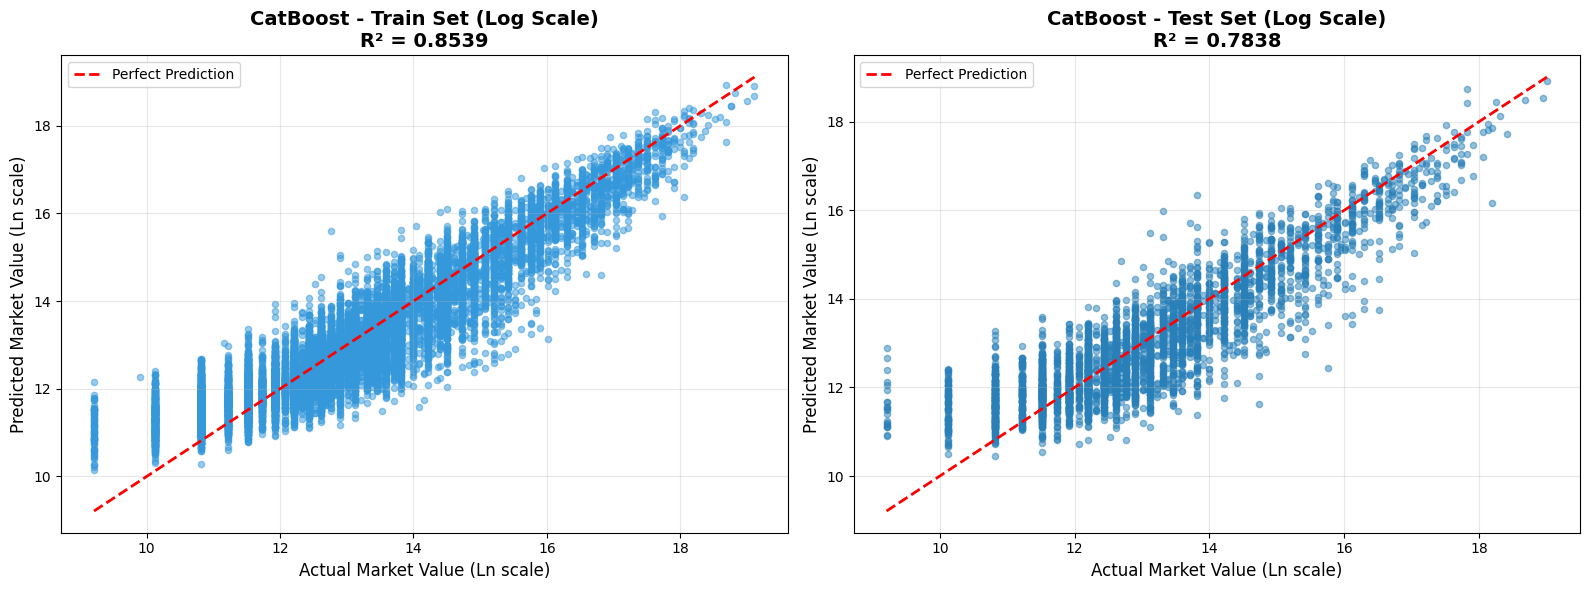

In [14]:
# Dự đoán Train
y_train_pred_cat = catboost_model.predict(X_train_cat)
y_test_pred_cat = catboost_model.predict(X_test_cat)

# Dự đoán Test
r2_train_cat = r2_score(y_train_cat, y_train_pred_cat)
r2_test_cat = r2_score(y_test_cat_aligned, y_test_pred_cat)

# --- BƯỚC 2: VẼ BIỂU ĐỒ ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- A. TRAIN SET (Bên Trái) ---
# Dùng màu Xanh dương (Blue) đặc trưng cho CatBoost
axes[0].scatter(y_train_cat, y_train_pred_cat, alpha=0.5, s=20, color='#3498db') 
axes[0].plot([y_train_cat.min(), y_train_cat.max()], 
             [y_train_cat.min(), y_train_cat.max()], 
             'r--', lw=2, label='Perfect Prediction')

axes[0].set_xlabel('Actual Market Value (Ln scale)', fontsize=12)
axes[0].set_ylabel('Predicted Market Value (Ln scale)', fontsize=12)
axes[0].set_title(f'CatBoost - Train Set (Log Scale)\nR² = {r2_train_cat:.4f}', 
                  fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# --- B. TEST SET (Bên Phải) ---
# Dùng màu Xanh dương đậm hơn
axes[1].scatter(y_test_cat, y_test_pred_cat, alpha=0.5, s=20, color='#2980b9')
axes[1].plot([y_test_cat.min(), y_test_cat.max()], 
             [y_test_cat.min(), y_test_cat.max()], 
             'r--', lw=2, label='Perfect Prediction')

axes[1].set_xlabel('Actual Market Value (Ln scale)', fontsize=12)
axes[1].set_ylabel('Predicted Market Value (Ln scale)', fontsize=12)
axes[1].set_title(f'CatBoost - Test Set (Log Scale)\nR² = {r2_test_cat:.4f}', 
                  fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 6. Feature Importance Analysis

Phân tích mức độ quan trọng của từng feature trong việc dự đoán giá trị cầu thủ.

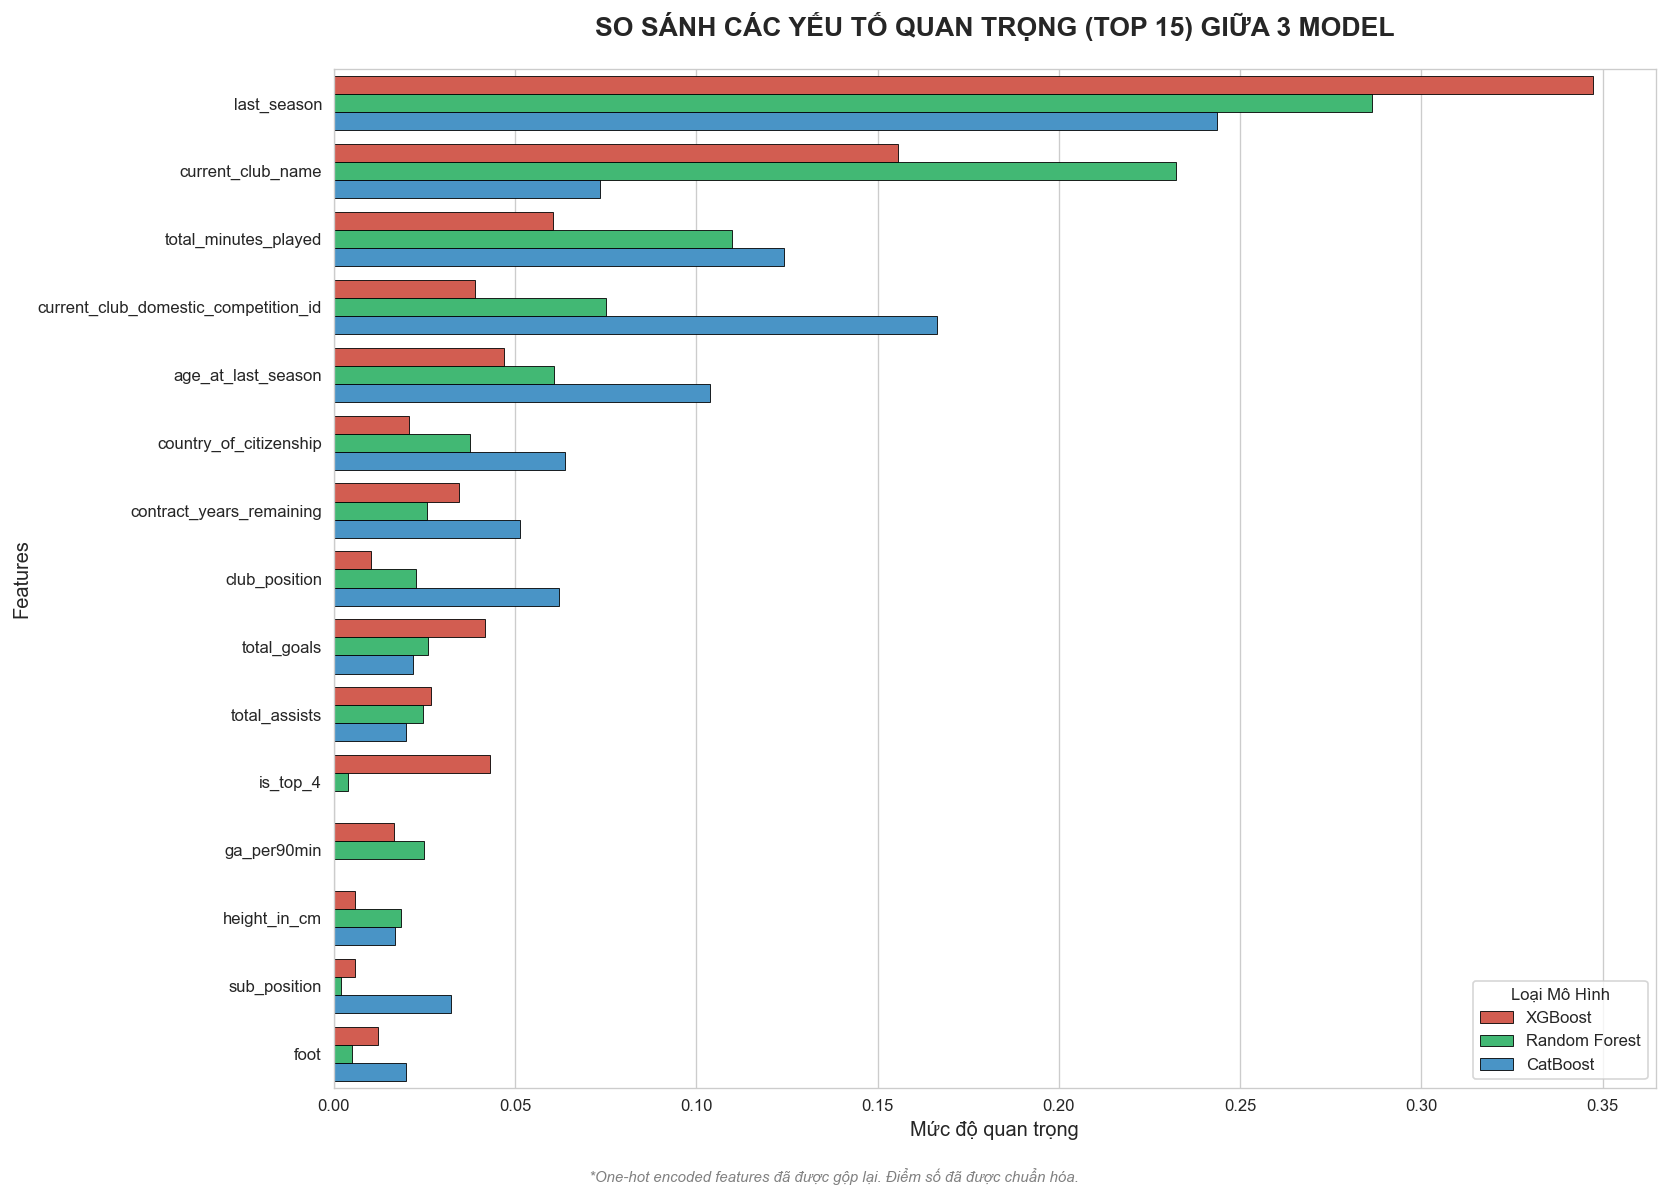


BẢNG CHI TIẾT ĐỘ QUAN TRỌNG (TOP 10)
                             Feature  XGBoost  Random Forest  CatBoost  Average
                         last_season   0.3474         0.2863    0.2436   0.2924
                   current_club_name   0.1557         0.2323    0.0736   0.1539
                total_minutes_played   0.0606         0.1098    0.1242   0.0982
current_club_domestic_competition_id   0.0389         0.0752    0.1664   0.0935
                  age_at_last_season   0.0469         0.0608    0.1038   0.0705
              country_of_citizenship   0.0209         0.0375    0.0639   0.0408
            contract_years_remaining   0.0345         0.0256    0.0514   0.0372
                       club_position   0.0102         0.0227    0.0623   0.0317
                         total_goals   0.0416         0.0261    0.0218   0.0298
                       total_assists   0.0268         0.0246    0.0198   0.0238


In [15]:
# MAPPING ONE-HOT FEATURES VỀ RAW FEATURES

def aggregate_onehot_importance(feature_names, importances):
    """
    Gộp các one-hot features thành feature gốc
    VD: foot_left, foot_right, foot_both → foot
    """
    feature_dict = {}
    
    for feat, imp in zip(feature_names, importances):
        # Tách tên feature gốc (trước dấu _)
        if '_' in feat and any(suffix in feat for suffix in ['_left', '_right', '_both', 
                                                               '_Centre-Forward', '_Winger']):
            base_feat = feat.rsplit('_', 1)[0]  # Lấy phần trước dấu _ cuối
        else:
            base_feat = feat
        
        # Cộng dồn importance
        if base_feat in feature_dict:
            feature_dict[base_feat] += imp
        else:
            feature_dict[base_feat] = imp
    
    return feature_dict

# Aggregate importances
xgb_agg = aggregate_onehot_importance(X_train.columns, xgb_model.feature_importances_)
rf_agg = aggregate_onehot_importance(X_train.columns, rf_model.feature_importances_)

# CatBoost đã ở dạng raw
cat_imp = catboost_model.get_feature_importance()
cat_imp_normalized = cat_imp / np.sum(cat_imp)
cat_agg = dict(zip(X_train_cat.columns, cat_imp_normalized))

# TẠO DATAFRAME SO SÁNH
# Lấy tất cả features unique
all_features = set(xgb_agg.keys()) | set(rf_agg.keys()) | set(cat_agg.keys())

comparison_data = []
for feat in all_features:
    comparison_data.append({
        'Feature': feat,
        'XGBoost': xgb_agg.get(feat, 0),
        'Random Forest': rf_agg.get(feat, 0),
        'CatBoost': cat_agg.get(feat, 0)
    })

df_importance = pd.DataFrame(comparison_data)

# Tính trung bình và sắp xếp
df_importance['Average'] = df_importance[['XGBoost', 'Random Forest', 'CatBoost']].mean(axis=1)
df_importance = df_importance.sort_values('Average', ascending=False)

# Lấy Top 15
top_features = df_importance.head(15)

# Melt để vẽ
df_melted = top_features.melt(
    id_vars=['Feature', 'Average'], 
    value_vars=['XGBoost', 'Random Forest', 'CatBoost'],
    var_name='Model', 
    value_name='Importance Score'
)

# VẼ BIỂU ĐỒ
plt.figure(figsize=(14, 10), dpi=120)
sns.set_style("whitegrid")

chart = sns.barplot(
    data=df_melted,
    x='Importance Score',
    y='Feature',
    hue='Model',
    palette={'XGBoost': '#e74c3c', 'Random Forest': '#2ecc71', 'CatBoost': '#3498db'},
    edgecolor='black',
    linewidth=0.5
)

plt.title('SO SÁNH CÁC YẾU TỐ QUAN TRỌNG (TOP 15) GIỮA 3 MODEL', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Mức độ quan trọng', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.legend(title='Loại Mô Hình', loc='lower right', fontsize=10)

# Thêm chú thích (sửa vị trí)
plt.figtext(0.5, 0.01, 
            '*One-hot encoded features đã được gộp lại. Điểm số đã được chuẩn hóa.',
            ha='center', fontsize=9, style='italic', color='gray')

plt.tight_layout(rect=[0, 0.03, 1, 1])  # Để chỗ cho chú thích
plt.show()

# IN BẢNG
print("\n" + "="*80)
print("BẢNG CHI TIẾT ĐỘ QUAN TRỌNG (TOP 10)")
print("="*80)
print(df_importance[['Feature', 'XGBoost', 'Random Forest', 'CatBoost', 'Average']]
      .head(10).to_string(index=False, float_format='%.4f'))
print("="*80)

### **➤ NHẬN XÉT TỔNG QUAN VỀ FEATURE IMPORTANCE**

#### 1. Câu trả lời cốt lõi: Yếu tố nào quyết định giá cầu thủ?
Dựa trên dữ liệu, câu trả lời rõ ràng là: **"Bối cảnh" (Context) quan trọng hơn "Hiệu suất" (Performance).**

Cả 3 mô hình đều đồng thuận rằng giá trị cầu thủ được định đoạt chủ yếu bởi **thời điểm** (`last_season`), **thương hiệu CLB** (`current_club_name`), và **nền tảng giải đấu** (`competition_id`), thay vì số lượng bàn thắng hay kiến tạo cụ thể.

*   **Bằng chứng:**
    *   `last_season` (Mùa giải) giữ vị trí **Top 1** tuyệt đối với trọng số trung bình là **0.29**.
    *   `current_club_name` (Tên CLB) giữ vị trí **Top 2** với trọng số trung bình **0.15**.
    *   Trong khi đó, `total_goals` (Bàn thắng) chỉ xếp hạng thấp với trọng số trung bình vỏn vẹn **0.029** (thấp hơn cả thẻ vàng ở một số model).

#### 2. Phân tích hành vi từng Model (Model Behavior Analysis)
Sự khác biệt trong cách 3 mô hình xếp hạng features cho thấy "khẩu vị" rủi ro và cách học dữ liệu khác nhau:

*   **XGBoost (The Inflation Tracker - *Người theo dõi lạm phát*):**
    *   **Số liệu:** Gán trọng số khổng lồ **0.35** cho `last_season`.
    *   **Ý nghĩa:** XGBoost nhận diện rằng thị trường chuyển nhượng có tính lạm phát cực cao. Cùng một bộ kỹ năng, cầu thủ năm 2023 sẽ đắt hơn năm 2015 rất nhiều. Đây là lý do XGBoost có R² cao nhất (**0.7997**) vì nó bắt được "trend" tăng giá theo thời gian tốt nhất.

*   **Random Forest (The Brand Bias - *Thiên kiến thương hiệu*):**
    *   **Số liệu:** Đặt trọng số **0.23** cho `current_club_name` (cao nhất trong 3 model).
    *   **Ý nghĩa:** Random Forest có xu hướng ghi nhớ (memorize) các giá trị định danh. Nó học theo kiểu: *"Nếu thuộc Real Madrid -> Giá cao"*. Điều này dẫn đến hạn chế là model này có R² thấp nhất (**0.6844**) trên tập Test, có thể do bị Overfitting vào tên các CLB trong tập Train và gặp khó khăn khi gặp các CLB lạ hoặc CLB mới lên hạng.

*   **CatBoost (The Structuralist - *Nhà cấu trúc học*):**
    *   **Số liệu:** Đánh giá `current_club_domestic_competition_id` lên tới **0.166** (gấp 4 lần XGBoost).
    *   **Ý nghĩa:** Đây là model có tư duy "logic bóng đá" nhất. Nó hiểu rằng **Giải đấu (League)** là yếu tố quyết định sàn giá trị. Một cầu thủ dự bị tại Premier League (Giải đấu ID cao) vẫn có giá trị cao hơn ngôi sao tại giải VĐQG Bỉ.

#### 3. Ý nghĩa thực tiễn & Domain Insights

*   **"Minutes" > "Goals" (Sự bền bỉ hơn Khoảnh khắc):**
    *   `total_minutes_played` (Avg 0.098) quan trọng **gấp 3 lần** `total_goals` (Avg 0.029).
    *   **Insight:** Các tuyển trạch viên và model đều đồng ý: Khả năng ra sân thường xuyên (availability) và là trụ cột của đội bóng là thước đo giá trị đáng tin cậy hơn số bàn thắng (vốn có thể bị nhiễu do may mắn hoặc vị trí thi đấu).

*   **Tuổi tác (`age_at_last_season`):**
    *   CatBoost đánh giá tuổi tác khá cao (**0.10**), trong khi XGBoost chỉ là **0.04**. Điều này cho thấy CatBoost nhạy bén hơn trong việc phát hiện quy luật *"Cầu thủ trẻ tiềm năng giá cao, cầu thủ già rớt giá"*.

#### 4. Những điểm bất thường (Surprises)

*   **Nghịch lý `contract_years_remaining` (Thời hạn hợp đồng):**
    *   Chỉ đạt trọng số trung bình **0.037**.
    *   **Bất ngờ:** Trong thực tế quản lý bóng đá, thời hạn hợp đồng là yếu tố sống còn (cầu thủ còn 5 năm hợp đồng phí chuyển nhượng rất cao). Việc AI đánh giá thấp yếu tố này gợi ý rằng dữ liệu đầu vào có thể chưa phản ánh đúng bản chất hợp đồng, hoặc mối quan hệ giữa "năm hợp đồng" và "giá trị" là phi tuyến tính phức tạp mà model chưa khai thác hết.

*   **Thẻ phạt (`total_yellow_cards`) tương đương Kiến tạo (`total_assists`):**
    *   Khá ngạc nhiên khi thẻ vàng (Avg 0.02) lại có tầm quan trọng xấp xỉ kiến tạo (Avg 0.023). Có thể thẻ vàng ở đây đóng vai trò là "proxy" cho sự năng nổ và tần suất tham gia tranh chấp (Aggression), đặc biệt với các hậu vệ/tiền vệ phòng ngự.

#### 5. Hạn chế (Limitations)

*   **Rủi ro phụ thuộc thời gian (Time-Dependency Risk):** Việc XGBoost phụ thuộc quá nhiều vào `last_season` (0.35) khiến model này rủi ro khi dự đoán cho tương lai xa (Out-of-time validation). Nếu thị trường bóng đá đóng băng hoặc giảm giá (như thời Covid), model sẽ dự đoán sai lệch lớn.
*   **Thiên kiến biến phân loại cao (High Cardinality Bias):** Random Forest bị bias nặng vào tên CLB. Nếu dùng model này để định giá cầu thủ từ một CLB mới thành lập hoặc ít tên tuổi, sai số sẽ rất lớn.

### **KẾT LUẬN**

Mặc dù **XGBoost** là model chiến thắng về mặt con số (R² ~0.80, RMSE thấp nhất), nhưng **CatBoost** là model chiến thắng về mặt **"Logic Bóng Đá"**.

*   **XGBoost** thắng nhờ bám sát xu hướng lạm phát thời gian (`last_season`).
*   **CatBoost** hiểu sâu sắc cấu trúc nền bóng đá (Giải đấu -> Thời lượng thi đấu -> Tuổi).

**Hướng đi đề xuất:** Để triển khai thực tế (Production), nên sử dụng phương pháp **Ensemble (Kết hợp)**: Lấy trọng số của XGBoost cho xu hướng giá, kết hợp với tư duy cấu trúc giải đấu của CatBoost để có một hệ thống định giá vừa chính xác về số liệu, vừa hợp lý về mặt chuyên môn.


### 7. Sample Predictions

Xem một số dự đoán cụ thể để hiểu rõ hơn về hiệu suất của mô hình.

In [16]:
# Tạo dataframe với predictions (sử dụng EUR scale cho dễ hiểu)
test_results = pd.DataFrame({
    'Actual_Value_EUR': y_test_eur.values,
    'Predicted_Value_EUR': y_test_pred_eur,
    'Absolute_Error_EUR': np.abs(y_test_eur.values - y_test_pred_eur),
    'Percentage_Error': np.abs((y_test_eur.values - y_test_pred_eur) / y_test_eur.values * 100)
})

# Top 10 dự đoán tốt nhất (sai số thấp nhất)
print("="*80)
print("TOP 10 DỰ ĐOÁN TỐT NHẤT (Sai số thấp nhất):")
print("="*80)
best_predictions = test_results.nsmallest(10, 'Absolute_Error_EUR')
for idx, row in best_predictions.iterrows():
    print(f"Actual: {row['Actual_Value_EUR']:>12,.0f} EUR | "
          f"Predicted: {row['Predicted_Value_EUR']:>12,.0f} EUR | "
          f"Error: {row['Absolute_Error_EUR']:>10,.0f} EUR ({row['Percentage_Error']:>5.2f}%)")

# Top 10 dự đoán tệ nhất (sai số cao nhất)
print("\n" + "="*80)
print("TOP 10 DỰ ĐOÁN TỆ NHẤT (Sai số cao nhất):")
print("="*80)
worst_predictions = test_results.nlargest(10, 'Absolute_Error_EUR')
for idx, row in worst_predictions.iterrows():
    print(f"Actual: {row['Actual_Value_EUR']:>12,.0f} EUR | "
          f"Predicted: {row['Predicted_Value_EUR']:>12,.0f} EUR | "
          f"Error: {row['Absolute_Error_EUR']:>10,.0f} EUR ({row['Percentage_Error']:>5.2f}%)")

NameError: name 'y_test_eur' is not defined

### 9. Results & Interpretation

#### Kết quả chính:

In [ ]:
# Tổng hợp kết quả
print("\n" + "="*80)
print("TỔNG HỢP KẾT QUẢ MÔ HÌNH XGBOOST")
print("="*80)

print("\n📊 METRICS TRÊN Ln SCALE:")
comparison_df_log = pd.DataFrame({
    'Metric': ['R² Score', 'MAE (Ln)', 'RMSE (Ln)'],
    'Train Set': [
        f"{train_metrics['R2_log']:.4f}",
        f"{train_metrics['MAE_log']:.4f}",
        f"{train_metrics['RMSE_log']:.4f}"
    ],
    'Test Set': [
        f"{test_metrics['R2_log']:.4f}",
        f"{test_metrics['MAE_log']:.4f}",
        f"{test_metrics['RMSE_log']:.4f}"
    ]
})
print(comparison_df_log.to_string(index=False))

print("\n" + "="*80)
print("💶 METRICS TRÊN EUR SCALE (INVERSE TRANSFORMED):")
comparison_df_eur = pd.DataFrame({
    'Metric': ['R² Score', 'MAE (EUR)', 'RMSE (EUR)', 'MAPE (%)'],
    'Train Set': [
        f"{train_metrics['R2_eur']:.4f}",
        f"{train_metrics['MAE_eur']:,.0f}",
        f"{train_metrics['RMSE_eur']:,.0f}",
        f"{train_metrics['MAPE_eur']:.2f}"
    ],
    'Test Set': [
        f"{test_metrics['R2_eur']:.4f}",
        f"{test_metrics['MAE_eur']:,.0f}",
        f"{test_metrics['RMSE_eur']:,.0f}",
        f"{test_metrics['MAPE_eur']:.2f}"
    ]
})
print(comparison_df_eur.to_string(index=False))
print("="*80)

# Đánh giá overfitting
r2_diff = train_metrics['R2_eur'] - test_metrics['R2_eur']
print(f"\nChênh lệch R² giữa Train và Test: {r2_diff:.4f}")
if r2_diff < 0.05:
    print("→ Mô hình KHÔNG bị overfitting (chênh lệch nhỏ)")
elif r2_diff < 0.15:
    print("→ Mô hình có dấu hiệu overfitting NHẸ")
else:
    print("→ Mô hình bị overfitting NGHIÊM TRỌNG")

### 10. Interpretation & Insights

#### Trả lời câu hỏi: Có thể dự đoán Market Value hay không?

**1. Độ chính xác của mô hình:**
- **R² Score**: Cho biết mô hình giải thích được bao nhiêu % biến động của giá trị cầu thủ
  - Nếu R² > 0.7: Mô hình rất tốt, có thể dự đoán hiệu quả
  - Nếu 0.5 < R² < 0.7: Mô hình khá tốt, có thể sử dụng với một số cảnh báo
  - Nếu R² < 0.5: Mô hình chưa đủ tốt để áp dụng thực tế

- **MAPE (Mean Absolute Percentage Error)**: Sai số phần trăm trung bình
  - Nếu MAPE < 20%: Dự đoán khá chính xác
  - Nếu 20% < MAPE < 40%: Dự đoán ở mức chấp nhận được
  - Nếu MAPE > 40%: Dự đoán kém chính xác

**2. Các yếu tố ảnh hưởng đến độ chính xác:**
- **Features quan trọng nhất**: Dựa vào Feature Importance để xác định
- **Chất lượng dữ liệu**: Missing values, outliers có thể ảnh hưởng
- **Độ phức tạp của thị trường**: Yếu tố phi lý tính (hype, marketing) không có trong data

**3. Khả năng áp dụng thực tế:**
- Mô hình có thể làm công cụ **tham khảo** cho việc định giá
- **KHÔNG nên** dùng làm công cụ duy nhất để ra quyết định
- Cần kết hợp với đánh giá chuyên môn từ scouts và analysts

**4. Hạn chế của mô hình:**
- Không capture được các yếu tố phi định lượng (tiềm năng phát triển, leadership, mindset)
- Không tính đến yếu tố cung-cầu của thị trường chuyển nhượng
-


In [ ]:
# Kết luận cuối cùng (dùng EUR metrics vì dễ hiểu hơn)
print("\n" + "="*80)
print("KẾT LUẬN")
print("="*80)

# Dùng R² và MAPE trên EUR scale để đánh giá
r2_test = test_metrics['R2_eur']
mape_test = test_metrics['MAPE_eur']

if r2_test > 0.7 and mape_test < 25:
    conclusion = "CÓ - Mô hình dự đoán hiệu quả"
    detail = f"""
    Mô hình XGBoost đạt R² = {r2_test:.4f} trên tập test (EUR scale), cho thấy 
    có thể dự đoán giá trị cầu thủ với độ chính xác cao. Mô hình giải thích được 
    {r2_test*100:.1f}% biến động của market value.
    
    MAPE = {mape_test:.2f}% cho thấy sai số trung bình ở mức chấp nhận được.
    MAE = {test_metrics['MAE_eur']:,.0f} EUR - sai số tuyệt đối trung bình.
    
    Mô hình CÓ THỂ được sử dụng làm công cụ hỗ trợ định giá cầu thủ
    Kết hợp với đánh giá chuyên môn sẽ cho kết quả tốt nhất
    Log transformation giúp mô hình xử lý tốt dải giá trị rộng
    """
elif r2_test > 0.5:
    conclusion = "CÓ - Nhưng với một số hạn chế"
    detail = f"""
    Mô hình XGBoost đạt R² = {r2_test:.4f} trên tập test (EUR scale), cho thấy 
    có thể dự đoán giá trị cầu thủ ở mức TRUNG BÌNH. Mô hình giải thích được 
    {r2_test*100:.1f}% biến động của market value.
    
    MAPE = {mape_test:.2f}% cho thấy sai số khá lớn trong một số trường hợp.
    MAE = {test_metrics['MAE_eur']:,.0f} EUR - sai số tuyệt đối trung bình.
    
    ⚠ Mô hình CÓ THỂ sử dụng nhưng cần thận trọng
    ⚠ Nên kết hợp chặt chẽ với đánh giá từ chuyên gia
    ⚠ Không nên dùng cho các quyết định quan trọng
    """
else:
    conclusion = "KHÔNG - Mô hình chưa đủ hiệu quả"
    detail = f"""
    Mô hình XGBoost chỉ đạt R² = {r2_test:.4f} trên tập test (EUR scale), cho thấy
    KHÔNG THỂ dự đoán giá trị cầu thủ một cách hiệu quả. Mô hình chỉ giải thích được 
    {r2_test*100:.1f}% biến động của market value.
    
    MAPE = {mape_test:.2f}% cho thấy sai số quá lớn.
    MAE = {test_metrics['MAE_eur']:,.0f} EUR - sai số tuyệt đối trung bình quá cao.
    
    ✗ Mô hình KHÔNG NÊN được sử dụng cho mục đích định giá thực tế
    ✗ Cần thu thập thêm dữ liệu hoặc features khác
    ✗ Có thể do thị trường chuyển nhượng phụ thuộc nhiều vào yếu tố phi lý tính
    """

print(f"\nCâu trả lời: {conclusion}")
print(detail)
print("\n💡 LƯU Ý: Mô hình sử dụng Ln transformation để xử lý tốt hơn")
print("   dải giá trị rộng của market value (từ vài nghìn đến hàng trăm triệu EUR)")
print("="*80)

### 11. Dùng mô hình dự đoán và so sánh kết quả đối với dữ liệu gốc 

In [ ]:
# 1. Load dữ liệu gốc để lấy thông tin thống kê cho việc mã hóa (Target Encoding)
# Giả sử bạn đã có df_raw từ file 'processed_players_data.csv'
if 'df_raw' not in locals():
    df_raw = pd.read_csv('../data/processed_players_data.csv')

# Tạo lại cột logarit của giá trị chuyển nhượng để làm cơ sở tính toán
# (Dùng Ln giống như cách bạn đã làm trong training)
df_raw['market_value_log'] = np.log1p(df_raw['market_value_in_eur'])

# 2. Tạo các bộ từ điển (Mapping dictionaries)
# Nguyên lý: Tính giá trị trung bình log(market_value) cho từng Club, Country, Competition
# Nếu gặp giá trị mới chưa từng thấy, ta sẽ dùng giá trị trung bình toàn cầu (global mean)

global_mean_mv = df_raw['market_value_log'].mean()

# Mapping cho CLB
club_map = df_raw.groupby('current_club_name')['market_value_log'].mean().to_dict()

# Mapping cho Quốc tịch
country_map = df_raw.groupby('country_of_citizenship')['market_value_log'].mean().to_dict()

# Mapping cho Giải đấu
comp_map = df_raw.groupby('current_club_domestic_competition_id')['market_value_log'].mean().to_dict()

print("Đã tạo xong bộ từ điển Mapping thành công!")
print(f"- Số lượng CLB đã học: {len(club_map)}")
print(f"- Số lượng Quốc tịch đã học: {len(country_map)}")
print(f"- Giá trị trung bình toàn cầu (Global Mean): {global_mean_mv:.4f}")

In [ ]:
def predict_player_value(player_data, model, feature_columns):
    """
    Hàm dự đoán giá trị cầu thủ từ dữ liệu thô.
    
    Args:
        player_data (dict): Dictionary chứa thông tin cầu thủ nhập tay.
        model: Mô hình XGBoost đã train.
        feature_columns (list): Danh sách các cột features được dùng lúc train (X_train.columns).
        
    Returns:
        DataFrame kết quả dự đoán (Log và EUR).
    """
    
    # 1. Khởi tạo DataFrame với tất cả các cột bằng 0, đúng theo cấu trúc lúc train
    input_df = pd.DataFrame(0, index=[0], columns=feature_columns)
    
    # 2. Điền các dữ liệu số cơ bản (Numerical Features)
    input_df['age_at_last_season'] = player_data.get('age', 25)
    input_df['height_in_cm'] = player_data.get('height', 180)
    input_df['total_goals'] = player_data.get('goals', 0)
    input_df['total_assists'] = player_data.get('assists', 0)
    input_df['total_minutes_played'] = player_data.get('minutes', 0)
    input_df['total_yellow_cards'] = player_data.get('yellow_cards', 0)
    input_df['total_red_cards'] = player_data.get('red_cards', 0)
    input_df['has_agent'] = 1 if player_data.get('has_agent', False) else 0
    input_df['ga_per90min'] = player_data.get('ga_per90min', 0.0)
    input_df['contract_years_remaining'] = player_data.get('contract_years', 1)
    input_df['club_position'] = player_data.get('club_rank', 10)
    
    # 3. [MỚI] Điền các thông tin bổ sung (Kiểm tra xem model có dùng cột này không trước khi điền)
    extra_fields = {
        'last_season': 'last_season', 
        'is_champion': 'is_champion', 
        'is_top_4': 'is_top_4', 
        'is_relegation': 'is_relegation'
    }
    
    for key, col_name in extra_fields.items():
        if col_name in input_df.columns:
            input_df[col_name] = player_data.get(key, 0)

    # 4. Xử lý Target Encoding (Sử dụng map đã tạo)
    # Club Name
    club_name = player_data.get('club_name', '')
    if 'current_club_name' in input_df.columns:
        input_df['current_club_name'] = club_map.get(club_name, global_mean_mv)
    
    # Country
    country = player_data.get('country', '')
    if 'country_of_citizenship' in input_df.columns:
        input_df['country_of_citizenship'] = country_map.get(country, global_mean_mv)
    
    # Competition
    comp = player_data.get('competition_id', '')
    if 'current_club_domestic_competition_id' in input_df.columns:
        input_df['current_club_domestic_competition_id'] = comp_map.get(comp, global_mean_mv)

    # 5. Xử lý One-Hot Encoding (Sub Position & Foot)
    # Sub Position
    sub_pos = player_data.get('sub_position', '') 
    sub_pos_col = f"sub_position_{sub_pos}"
    if sub_pos_col in input_df.columns:
        input_df[sub_pos_col] = 1
        
    # Foot
    foot = player_data.get('foot', '')
    foot_col = f"foot_{foot}"
    if foot_col in input_df.columns:
        input_df[foot_col] = 1

    # 6. Thực hiện dự đoán
    try:
        pred_log = model.predict(input_df)[0]
        pred_eur = np.expm1(pred_log)  # Dùng expm1 vì train bằng log1p
        return input_df, pred_log, pred_eur
    except Exception as e:
        print(f"Lỗi khi dự đoán: {e}")
        return input_df, 0, 0

In [ ]:
# -Nhập dữ liệu cầu thủ dự đoán tại đây
new_player = {
    # Thông tin cơ bản
    'age': 32,
    'height': 170,                 # cm
    'country': 'Argentina',            # Phải gõ đúng tên tiếng Anh như trong dữ liệu gốc
    
    # Vị trí và Chân thuận
    'sub_position': 'Right Winger',  # Ví dụ: Centre-Forward, Centre-Back, Left Winger...
    'foot': 'left',                     # 'left' hoặc 'right'
    
    # CLB và Giải đấu
    'club_name': 'Futbol Club Barcelona',         # Tên CLB hiện tại
    'competition_id': 'laliga',          # bundesliga, premier-league, laliga, serie-a...
    'club_rank': 1.0,                    # Thứ hạng của CLB mùa trước
    
    # Thống kê mùa giải
    'goals': 46,
    'assists': 17,
    'minutes': 3000,
    'yellow_cards': 7,
    'red_cards': 0,
    'ga_per90min': 1.89,                  # (Goals + Assists) / 90 mins
    
    # Hợp đồng
    'has_agent': False,                   # Có người đại diện hay không
    'contract_years': 2,                  # Số năm hợp đồng còn lại
    
    # Thông tin bổ sung
    'last_season': 2025,                  # Mùa giải gần nhất
    'is_champion': 1,                     # CLB có vô địch không (0 hoặc 1)
    'is_top_4': 1,                        # CLB có vào top 4 không (0 hoặc 1)
    'is_relegation': 0                    # CLB có xuống hạng không (0 hoặc 1)
}

# Gọi hàm dự đoán
try:
    # Lấy danh sách features từ X_train (đã chạy ở cell train trước đó)
    feature_cols = X_train.columns.tolist()
    
    # Thực hiện dự đoán
    input_df_processed, pred_log, pred_eur = predict_player_value(new_player, xgb_model, feature_cols)

    print("-" * 50)
    print(f"DỰ ĐOÁN GIÁ TRỊ CHUYỂN NHƯỢNG (MARKET VALUE)")
    print("-" * 50)
    print(f"Thông tin cầu thủ đã nhập:")
    print(f"  - Tuổi: {new_player['age']}")
    print(f"  - Chiều cao: {new_player['height']} cm")
    print(f"  - Quốc tịch: {new_player['country']}")
    print(f"  - Vị trí: {new_player['sub_position']}")
    print(f"  - Chân thuận: {'Trái' if new_player['foot'] == 'left' else 'Phải'}")
    print(f"  - Câu lạc bộ: {new_player['club_name']}")
    print(f"  - Giải đấu: {new_player['competition_id']}")
    print(f"  - Thứ hạng CLB: {new_player['club_rank']}")
    print(f"  - Bàn thắng: {new_player['goals']}")
    print(f"  - Kiến tạo: {new_player['assists']}")
    print(f"  - Phút thi đấu: {new_player['minutes']}")
    print(f"  - Thẻ vàng: {new_player['yellow_cards']}")
    print(f"  - Thẻ đỏ: {new_player['red_cards']}")
    print(f"  - G+A/90 phút: {new_player['ga_per90min']}")
    print(f"  - Có người đại diện: {'Có' if new_player['has_agent'] else 'Không'}")
    print(f"  - Số năm hợp đồng còn lại: {new_player['contract_years']}")
    print(f"  - Mùa giải: {new_player['last_season']}")
    print(f"  - Vô địch: {'Có' if new_player['is_champion'] == 1 else 'Không'}")
    print(f"  - Top 4: {'Có' if new_player['is_top_4'] == 1 else 'Không'}")
    print(f"  - Xuống hạng: {'Có' if new_player['is_relegation'] == 1 else 'Không'}")
    print("-" * 50)
    print(f"Kết quả dự đoán (Ln scale):  {pred_log:.4f}")
    print(f"Kết quả dự đoán (EUR):          € {pred_eur:,.0f}")
    print("-" * 50)
    
except NameError:
    print("Lỗi: Bạn cần chạy các cell huấn luyện mô hình (fit model) để có biến 'xgb_model' và 'X_train' trước khi chạy cell này.")
except Exception as e:
    print(f"Đã xảy ra lỗi: {e}")

In [ ]:
# --- 1. LẤY MẪU NGẪU NHIÊN 10 CẦU THỦ TỪ DỮ LIỆU GỐC ---
# Chúng ta dùng file gốc vì file encoded (test_data_encoded) đã bị mất cột Tên cầu thủ

# Lấy ngẫu nhiên 10 cầu thủ
# (Để đảm bảo tính khách quan, lý tưởng nhất là lọc những index thuộc tập Test, 
# nhưng ở đây ta lấy ngẫu nhiên để demo nhanh khả năng dự đoán)
# random_samples = df_raw.sample(n=10, random_state=42) # random_state để kết quả cố định mỗi lần chạy
random_samples = df_raw.sample(n=10) # Lấy ngẫu nhiên mỗi lần chạy

print(f"{'TÊN CẦU THỦ':<25} | {'THỰC TẾ (€)':<13} | {'DỰ ĐOÁN (€)':<13} | {'CHÊNH LỆCH (€)':<13} | {'SAI SỐ (%)':<10}")
print("-" * 85)

results = []
feature_cols = X_train.columns.tolist() # Danh sách cột features từ model đã train

# --- 2. DỰ ĐOÁN VÀ SO SÁNH ---
for index, row in random_samples.iterrows():
    # A. Chuẩn bị dữ liệu input từ dòng hiện tại (Mapping từ cột CSV sang key của hàm predict)
    player_input = {
        'age': row['age_at_last_season'],
        'height': row['height_in_cm'],
        'country': row['country_of_citizenship'],
        'sub_position': row['sub_position'],
        'foot': row['foot'],
        'club_name': row['current_club_name'],
        'competition_id': row['current_club_domestic_competition_id'],
        'club_rank': row['club_position'],
        'goals': row['total_goals'],
        'assists': row['total_assists'],
        'minutes': row['total_minutes_played'],
        'yellow_cards': row['total_yellow_cards'],
        'red_cards': row['total_red_cards'],
        'ga_per90min': row['ga_per90min'],
        'has_agent': row['has_agent'],
        'contract_years': row['contract_years_remaining'],
        'last_season': row['last_season'],
        'is_champion': row['is_champion'],
        'is_top_4': row['is_top_4'],
        'is_relegation': row['is_relegation']
    }

    # Xử lý dữ liệu thiếu (nếu có)
    if pd.isna(player_input['sub_position']): player_input['sub_position'] = 'Unknown'
    if pd.isna(player_input['foot']): player_input['foot'] = 'right'

    # B. Gọi hàm dự đoán
    try:
        _, pred_log, pred_eur = predict_player_value(player_input, xgb_model, feature_cols)
        
        # C. Lấy giá trị thực tế
        actual_eur = row['market_value_in_eur']
        
        # D. Tính toán sai số
        diff = pred_eur - actual_eur
        error_percent = (abs(diff) / actual_eur) * 100
        
        results.append(error_percent)
        
        # E. In kết quả từng dòng
        name_display = (row['name'][:30] + '..') if len(row['name']) > 30 else row['name']
        
        print(f"{name_display:<25} | {actual_eur:>13,.0f} | {pred_eur:>13,.0f} | {diff:>+13,.0f} | {error_percent:>9.2f}%")
        
    except Exception as e:
        print(f"Lỗi khi dự đoán cầu thủ {row['name']}: {e}")

print("-" * 85)

# --- 3. TỔNG KẾT ĐỘ CHÍNH XÁC ---
if results:
    mape = np.mean(results) # Mean Absolute Percentage Error
    accuracy_proxy = 100 - mape
    
    print(f"\n>> TỔNG KẾT TRÊN 10 CẦU THỦ NGẪU NHIÊN:")
    print(f"   - Trung bình sai số (MAPE): {mape:.2f}%")
    print(f"   - Độ chính xác ước tính (100% - MAPE): {accuracy_proxy:.2f}%")
    
    if accuracy_proxy < 0:
        print("   (Lưu ý: Độ chính xác âm cho thấy sai số trung bình lớn hơn 100%, mô hình cần cải thiện thêm)")

### Đánh giá kết quả và hiệu suất

Vì chúng ta đã Log-transform biến mục tiêu (`market_value_log`) ở bước tiền xử lý, nên sau khi dự đoán xong, cần sử dụng hàm mũ (`np.exp`) để đưa kết quả về đơn vị tiền tệ thực tế (EUR) trước khi tính toán sai số.

In [ ]:
# 1. Dự đoán trên tập Test
y_pred_log = rf_model.predict(X_test)

# 2. Chuyển đổi ngược từ Log về giá trị thực (EUR)
y_test_eur = np.exp(y_test) 
y_pred_eur = np.exp(y_pred_log)

# 3. Tính toán các chỉ số đánh giá
mae = mean_absolute_error(y_test_eur, y_pred_eur)
rmse = np.sqrt(mean_squared_error(y_test_eur, y_pred_eur))
mape = np.mean(np.abs((y_test_eur - y_pred_eur) / y_test_eur)) * 100
r2 = r2_score(y_test_eur, y_pred_eur)

print(" KẾT QUẢ ĐÁNH GIÁ (Random Forest) ")
print(f"R-squared: {r2:.4f}")
print(f"Mean Absolute Error (MAE): €{mae:,.0f}")
print(f"Root Mean Squared Error (RMSE): €{rmse:,.0f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Vẽ biểu đồ so sánh Thực tế vs Dự đoán
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_eur, y=y_pred_eur, alpha=0.6)
plt.plot([y_test_eur.min(), y_test_eur.max()], [y_test_eur.min(), y_test_eur.max()], 'r--', lw=2)
plt.xlabel('Giá trị thực tế (EUR)')
plt.ylabel('Giá trị dự đoán (EUR)')
plt.title('Random Forest: Thực tế vs Dự đoán')
plt.xscale('log') # Dùng scale log để dễ nhìn các giá trị nhỏ và lớn
plt.yscale('log')
plt.grid(True)
plt.show()

### Nhận xét biểu đồ:

Biểu đồ trên cho thấy mối tương quan giữa giá trị thị trường thực tế và giá trị do mô hình Random Forest dự đoán:

* **Độ fit:** Các điểm dữ liệu tập trung khá sát quanh đường chéo màu đỏ, thể hiện qua chỉ số **$R^2 \approx 0.73$**. Điều này có nghĩa là mô hình giải thích được khoảng **73%** sự biến thiên của giá trị cầu thủ dựa trên các dữ liệu đầu vào.
* **Phân phối lỗi:**
    * Ở phân khúc giá trị thấp, các điểm dữ liệu co cụm tốt hơn.
    * Ở phân khúc giá trị cao (siêu sao), các điểm dữ liệu có xu hướng phân tán rộng hơn. Điều này được phản ánh qua sự chênh lệch lớn giữa **MAE (€1M)** và **RMSE (€4M)**, cho thấy mô hình đôi khi mắc sai số rất lớn đối với các cầu thủ đắt giá (outliers).

### Feature Importance

Một lợi thế của Random Forest là cho biết feature nào đóng góp nhiều nhất vào việc định giá cầu thủ. Điều này giúp trả lời câu hỏi: "Yếu tố nào quyết định giá trị cầu thủ?"

In [ ]:

feature_names = X_train.columns if hasattr(X_train, 'columns') else [f"Feature {i}" for i in range(X_train.shape[1])]
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1] # Sắp xếp giảm dần

# Chỉ lấy Top 15 features quan trọng nhất để vẽ
top_n = 15
top_indices = indices[:top_n]

plt.figure(figsize=(12, 8))
plt.title(f"Top {top_n} yếu tố ảnh hưởng đến giá trị cầu thủ")
plt.barh(range(top_n), importances[top_indices], align="center", color='skyblue')
plt.yticks(range(top_n), [feature_names[i] for i in top_indices])
plt.gca().invert_yaxis() # Đảo ngược trục y để feature quan trọng nhất nằm trên cùng
plt.xlabel("Mức độ quan trọng (Importance Score)")
plt.show()

### Nhận xét biểu đồ:
Biểu đồ trên giúp chúng ta hiểu cách mô hình Random Forest được huấn luyện khi định giá một cầu thủ. Các yếu tố nằm ở trên cùng là những yếu tố quan trọng nhất:
1.  **Các đặc trưng hàng đầu:** Thông thường, các chỉ số như **Tuổi tác (Age)**, **Số phút thi đấu**, **Số bàn thắng/kiến tạo** và **Hạng giải đấu** sẽ chiếm tỷ trọng cao nhất. Điều này phù hợp với thực tế: cầu thủ trẻ, đá chính thường xuyên ở giải đấu lớn và có hiệu suất cao sẽ có giá trị lớn.
2.  **Loại bỏ các đặc trưng gây nhiễu:** Các đặc trưng nằm ở đáy biểu đồ có đóng góp không đáng kể. Việc loại này giúp chúng ta có thể tối ưu hóa mô hình, giảm bớt sự tính toán mà không làm giảm độ chính xác của mô hình.

## Kết luận: Có thể dự đoán Market Value hay không?
Dựa trên kết quả với mô hình Random Forest, chúng ta có thể trả lời câu hỏi nghiên cứu như sau:

### 1. Đánh giá độ chính xác
**Câu trả lời:** Có thể dự đoán được, nhưng khó dự đoán chính xác **con số cụ thể**.

* **Điểm tích cực:** Với $R^2 \approx 0.73$, mô hình thành công trong việc phân loại cầu thủ. Nó phân biệt tốt giữa một cầu thủ giá €500k, €5M và €50M.
* **Điểm hạn chế:** Chỉ số **MAPE lên tới 73.04%** là một con số khá cao. Điều này có nghĩa là trung bình mô hình đang dự đoán sai lệch khoảng 73% so với giá thực. Ví dụ: Một cầu thủ giá €10M có thể bị định giá lệch thành €2.7M hoặc €17.3M.

### 2. Các yếu tố ảnh hưởng đến độ chính xác
* **Outliers:** Thị trường chuyển nhượng có những "bom tấn", ảo giá, làm tăng đáng kể chỉ số RMSE.

### 3. Khả năng áp dụng thực tế & Hạn chế
* **Ứng dụng:**
    * **Sàng lọc:** Hỗ trợ Scout tìm kiếm các cầu thủ "Undervalued" (Giá trị thực tế thấp hơn giá trị mô hình dự đoán -> Có tiềm năng mua hời).
    * **Hỗ trợ đàm phán lương:** Đưa ra mức giá sàn để thương lượng và kí kết hợp đồng.
* **Hạn chế:**
    * Không thể dùng làm công cụ định giá chính xác.
    * Mô hình hiện tại có sai số lớn đối với các siêu sao, cần các kỹ thuật phức tạp hơn hoặc thêm dữ liệu về thương mại/truyền thông để cải thiện.

### III. Cat boost

In [ ]:
df = pd.read_csv("../data/processed_players_data.csv")

# 2. Định nghĩa biến mục tiêu và biến độc lập (features)
TARGET_COLUMN = 'market_value_in_eur'

# Danh sách features được yêu cầu (đã điều chỉnh từ yêu cầu của bạn)
FEATURE_COLUMNS = [
    'age_at_last_season',
    'height_in_cm',
    'club_position',
    'total_goals',
    'total_assists',
    'total_minutes_played',
    'total_yellow_cards',
    'total_red_cards',
    'has_agent',
    'ga_per90min',
    'contract_years_remaining',
    'last_season',
    'is_champion',
    'is_top_4',
    'is_relegation',
    'current_club_name',
    'country_of_citizenship',
    'current_club_domestic_competition_id',
    'sub_position',
    'foot'
]

# 3. Chuẩn bị dữ liệu
X = df[FEATURE_COLUMNS]
y = df[TARGET_COLUMN]

# Kiểm tra và loại bỏ các hàng có giá trị NaN trong các cột feature và target đã chọn (nếu có, dù đã kiểm tra ban đầu là không có)
# Tuy nhiên, CatBoost có khả năng xử lý NaN, nhưng để đơn giản và tập trung vào các bước chính, ta giả định dữ liệu sạch.

# 4. Xác định các biến phân loại (CatBoost tự động xử lý mã hóa, không cần One-Hot Encoding)
CATEGORICAL_FEATURES = [
    'current_club_name',
    'country_of_citizenship',
    'current_club_domestic_competition_id',
    'sub_position',
    'foot'
]

# Đảm bảo các cột phân loại có kiểu dữ liệu là 'object' hoặc 'category'
for col in CATEGORICAL_FEATURES:
    if col in X.columns:
        X[col] = X[col].astype('str') # CatBoost hoạt động tốt với str cho categorical

# 5. Chia dữ liệu thành tập huấn luyện (training) và tập kiểm tra (testing)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Kích thước tập huấn luyện: {X_train.shape}")
print(f"Kích thước tập kiểm tra: {X_test.shape}")


# 6. Khởi tạo và Huấn luyện mô hình CatBoost Regressor
# Sử dụng 'RMSE' làm metric chính (loss_function)
print("\nBắt đầu huấn luyện mô hình CatBoost...")

# CatBoostRegressor(
#     iterations=1000,
#     learning_rate=0.05,
#     depth=10,
#     loss_function='RMSE',
#     random_seed=42,
#     verbose=100, # In thông báo sau mỗi 100 lần lặp
# )
model = CatBoostRegressor(
    iterations=500, # Giảm số lần lặp cho ví dụ nhanh hơn
    learning_rate=0.05,
    depth=8,
    loss_function='RMSE',
    random_seed=42,
    cat_features=CATEGORICAL_FEATURES,
    verbose=100, # In thông báo sau mỗi 100 lần lặp
    early_stopping_rounds=20 # Dừng sớm nếu không cải thiện
)

model.fit(
    X_train,
    y_train,
    eval_set=(X_test, y_test),
    plot=False # Thiết lập plot=True trong notebook để xem biểu đồ huấn luyện
)

print("Huấn luyện hoàn tất.")


# 7. Đánh giá mô hình trên tập kiểm tra
y_pred = model.predict(X_test)

# Tính toán các chỉ số đánh giá
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = model.score(X_test, y_test)

print("\n--- Kết quả đánh giá trên tập kiểm tra ---")
print(f"Mean Absolute Error (MAE): {mae:,.2f} EUR")
print(f"Root Mean Squared Error (RMSE): {rmse:,.2f} EUR")
print(f"R-squared (R2 Score): {r2:.4f}")

# 8. Xem xét tầm quan trọng của các Features
print("\n--- Tầm quan trọng của các Features (Feature Importance) ---")
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.get_feature_importance()
}).sort_values(by='Importance', ascending=False)

print(feature_importance)